# INTRODUCTION

## Goal

The goal of the problem is to predict whether a passenger was satisfied or not considering his/her overall experience of traveling on the Shinkansen Bullet Train.

## Dataset

The problem consists of 2 separate datasets: Travel data & Survey data. Travel data has information related to passengers and attributes related to the Shinkansen train, in which they traveled. The survey data is aggregated data of surveys indicating the post-service experience. You are expected to treat both these datasets as raw data and perform any necessary data cleaning/validation steps as required.

# SET UP

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
!pip install polars

In [3]:
# data processing lib
import numpy as np
import pandas as pd
import polars as pl
from scipy import stats

# data viz lib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly import subplots

# ML lib
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [4]:
train_travel_link = "https://raw.githubusercontent.com/amrirasyidi/mit_idss_hackaton/main/data/Traveldata_train.csv"
train_survey_link = "https://raw.githubusercontent.com/amrirasyidi/mit_idss_hackaton/main/data/Surveydata_train.csv"

test_travel_link = "https://raw.githubusercontent.com/amrirasyidi/mit_idss_hackaton/main/data/Traveldata_test.csv"
test_survey_link = "https://raw.githubusercontent.com/amrirasyidi/mit_idss_hackaton/main/data/Surveydata_test.csv"

## Polars

In [5]:
train_travel_pl = pl.read_csv(train_travel_link, infer_schema_length=0).lazy()
train_survey_pl = pl.read_csv(train_survey_link, infer_schema_length=0).lazy()

test_travel_pl = pl.read_csv(test_travel_link, infer_schema_length=0).lazy()
test_survey_pl = pl.read_csv(test_survey_link, infer_schema_length=0).lazy()

### Travel

In [6]:
# rename columns

COLUMN_MAPPING = {col:col.lower() for col in train_travel_pl.columns}
train_travel_pl = train_travel_pl.rename(COLUMN_MAPPING)

In [7]:
train_travel_pl = train_travel_pl.with_column(
    pl.col([
        "id",
        "age",
        "travel_distance",
        "departure_delay_in_mins",
        "arrival_delay_in_mins",
        ]).cast(pl.Int64, strict=False)
)

In [8]:
train_travel_pl.head().collect()

id,gender,customer_type,age,type_travel,travel_class,travel_distance,departure_delay_in_mins,arrival_delay_in_mins
i64,str,str,i64,str,str,i64,i64,i64
98800001,"""Female""","""Loyal Customer...",52,null,"""Business""",272,0,5
98800002,"""Male""","""Loyal Customer...",48,"""Personal Trave...","""Eco""",2200,9,0
98800003,"""Female""","""Loyal Customer...",43,"""Business Trave...","""Business""",1061,77,119
98800004,"""Female""","""Loyal Customer...",44,"""Business Trave...","""Business""",780,13,18
98800005,"""Female""","""Loyal Customer...",50,"""Business Trave...","""Business""",1981,0,0


## Pandas

### Travel

In [9]:
train_travel = pd.read_csv(train_travel_link)
train_survey = pd.read_csv(train_survey_link)

test_travel = pd.read_csv(test_travel_link)
test_survey = pd.read_csv(test_survey_link)

In [10]:
# Overview of the travel data
train_travel.head(3)

,ID,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins
0,98800001,Female,Loyal Customer,52.0,NaN,Business,272,0.0,5.0
1,98800002,Male,Loyal Customer,48.0,Personal Travel,Eco,2200,9.0,0.0
2,98800003,Female,Loyal Customer,43.0,Business Travel,Business,1061,77.0,119.0


In [11]:
# Statistics of the travel data
train_travel.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,94379.0,9.884719e+07,27245.014865,98800001.0,98823595.5,98847190.0,98870784.5,98894379.0
Age,94346.0,3.941965e+01,15.116632,7.0,27.0,40.0,51.0,85.0
Travel_Distance,94379.0,1.978888e+03,1027.961019,50.0,1359.0,1923.0,2538.0,6951.0
Departure_Delay_in_Mins,94322.0,1.464709e+01,38.138781,0.0,0.0,0.0,12.0,1592.0
Arrival_Delay_in_Mins,94022.0,1.500522e+01,38.439409,0.0,0.0,0.0,13.0,1584.0


In [12]:
# Info of the travel data
train_travel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       94379 non-null  int64  
 1   Gender                   94302 non-null  object 
 2   Customer_Type            85428 non-null  object 
 3   Age                      94346 non-null  float64
 4   Type_Travel              85153 non-null  object 
 5   Travel_Class             94379 non-null  object 
 6   Travel_Distance          94379 non-null  int64  
 7   Departure_Delay_in_Mins  94322 non-null  float64
 8   Arrival_Delay_in_Mins    94022 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 6.5+ MB


In [13]:
# check duplicates
print("Is there any duplicate in the data? ",train_travel.duplicated().any())

Is there any duplicate in the data?  False


In [14]:
# rename columns

COLUMN_MAPPING = {col:col.lower() for col in train_travel.columns}
train_travel = train_travel.rename(columns = COLUMN_MAPPING)

### Survey

In [15]:
train_survey.head(3)

,ID,Overall_Experience,Seat_Comfort,Seat_Class,Arrival_Time_Convenient,Catering,Platform_Location,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding
0,98800001,0,Needs Improvement,Green Car,Excellent,Excellent,Very Convenient,Good,Needs Improvement,Acceptable,Needs Improvement,Needs Improvement,Acceptable,Needs Improvement,Good,Needs Improvement,Poor
1,98800002,0,Poor,Ordinary,Excellent,Poor,Needs Improvement,Good,Poor,Good,Good,Excellent,Needs Improvement,Poor,Needs Improvement,Good,Good
2,98800003,1,Needs Improvement,Green Car,Needs Improvement,Needs Improvement,Needs Improvement,Needs Improvement,Good,Excellent,Excellent,Excellent,Excellent,Excellent,Good,Excellent,Excellent


In [16]:
train_survey.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,94379.0,9.884719e+07,27245.014865,98800001.0,98823595.5,98847190.0,98870784.5,98894379.0
Overall_Experience,94379.0,5.466576e-01,0.497821,0.0,0.0,1.0,1.0,1.0


In [17]:
train_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ID                       94379 non-null  int64 
 1   Overall_Experience       94379 non-null  int64 
 2   Seat_Comfort             94318 non-null  object
 3   Seat_Class               94379 non-null  object
 4   Arrival_Time_Convenient  85449 non-null  object
 5   Catering                 85638 non-null  object
 6   Platform_Location        94349 non-null  object
 7   Onboard_Wifi_Service     94349 non-null  object
 8   Onboard_Entertainment    94361 non-null  object
 9   Online_Support           94288 non-null  object
 10  Ease_of_Online_Booking   94306 non-null  object
 11  Onboard_Service          86778 non-null  object
 12  Legroom                  94289 non-null  object
 13  Baggage_Handling         94237 non-null  object
 14  CheckIn_Service          94302 non-nul

In [18]:
# rename columns

COLUMN_MAPPING_SURVEY = {col:col.lower() for col in train_survey.columns}
train_survey = train_survey.rename(columns = COLUMN_MAPPING_SURVEY)

In [19]:
# to unify the rating, we will convert values in platform_location column

odd_val = [
    "Very Inconvenient",
    "Inconvenient",
    "Needs Improvement",
    "Manageable",
    "Convenient",
    "Very Convenient"
    ]

correct_val = [
    "Extremely Poor",
    "Poor",
    "Needs Improvement",
    "Acceptable",
    "Good",
    "Excellent"
]

encoded_val = [0,1,2,3,4,5]

VALUE_MAPPING_SURVEY = dict(zip(odd_val,correct_val))

In [20]:
train_survey['platform_location'] = train_survey['platform_location'].map(VALUE_MAPPING_SURVEY)

### Some changes made

- train_travel
  - rename column
- train_survey
  - rename column
  - unify rating name

## Classes and Functions

In [21]:
# transforming categorical column into numerical labels
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

# visualize null count as horizontal bar plot
def null_viz(data = train_travel):
  NULL_COUNT = pd.DataFrame(data.isna().sum()).reset_index().rename(columns = {'index':'variable',0:'count'}).sort_values(by='count')
  NULL_COUNT['pct'] = (NULL_COUNT['count']/data.shape[0])

  fig, ax = plt.subplots(figsize = (15,6))

  width = .8

  bars = NULL_COUNT['count'].plot.barh(color='green', ax=ax, width=width)

  for i, v in enumerate(NULL_COUNT['pct']):
      ax.text(v + 100, i, '{:.2%}'.format(v), fontweight='bold')

  ax.set_ylabel('Variable');
  ax.set_yticklabels(NULL_COUNT.variable.to_list());

  ax.set_xlabel('Count');

  ax.set_title("Null Value \nCount and Percentage", fontsize=20, fontweight='bold', fontfamily='monospace')

  return (fig, ax)

# visualize categorical variable distribution as horizontal bar plot
def cat_distribution(data = train_travel, nrows = 2, ncols = 2, width = 15, height = 6, val_order = 'count'):
  fig, ax = plt.subplots(nrows,ncols, figsize = (width,height))
  plt.suptitle("Distribution of\nCategorical Variables", fontsize=20, fontweight='bold', fontfamily='monospace', y = 1.05)

  col = data.select_dtypes(exclude=np.number).columns.tolist()

  for var,axs in zip(col, ax.flatten()):
    if val_order == 'count':
      orders = data[var].fillna("Null").value_counts().index
    else:
      orders = ["Null"]+correct_val
      orders = orders[::-1]

    cnt = sns.countplot(
        y = data[var].fillna("Null"),
        ax = axs,
        color = 'lightblue',
        order = orders
    )

    cnt.set_ylabel('')
    cnt.set_title(var, fontweight = 'bold', fontsize = 16)

  plt.tight_layout()

  return (fig, ax)

# visualize numerical variable distribution as histogram
def num_distribution(data = train_travel, nrows = 2, ncols = 2, width = 15, height = 6):
  fig, ax = plt.subplots(nrows,ncols, figsize = (width,height))
  plt.suptitle("Distribution of\nNumerical Variables", fontsize=20, fontweight='bold', fontfamily='monospace', y = 1.1)

  col = data.select_dtypes(include=np.number).columns.tolist()[1:]

  for var,axs in zip(col, ax.flatten()):
    cnt = sns.histplot(
        x = data[var],
        ax = axs,
        color = 'lightblue'
    )

    cnt.set_ylabel('')
    cnt.set_title(var, fontweight = 'bold', fontsize = 16)

  plt.tight_layout()

  return (fig, ax)

# visualize variable correlation heatmap
def corr_heatmap(data = train_travel, width = 16, height = 12):
  # https://www.kdnuggets.com/2021/04/awesome-tricks-best-practices-kaggle.html

  # Calculate pairwise-correlation
  matrix = data.corr()

  # Create a mask
  mask = np.triu(np.ones_like(matrix, dtype=bool))

  # Create a custom diverging palette
  cmap = sns.diverging_palette(250, 15, s=75, l=40,n=9, 
                              center="light", 
                              as_cmap=True
                              )

  plt.figure(figsize=(width, height))
  plt.title("Variable Correlation Heatmap", fontsize=20, fontweight='bold', fontfamily='monospace')
  sns.heatmap(matrix, mask=mask, center=0, annot=True, 
              fmt='.2f', square=True, cmap=cmap)
  
  return (fig, ax)

# EXPLORATION

## Travel

In [22]:
NULL_COUNT = pd.DataFrame(train_travel.isna().sum()).reset_index().rename(columns = {'index':'variable',0:'count'}).sort_values(by='count')
NULL_COUNT['pct'] = (NULL_COUNT['count']/train_travel.shape[0])

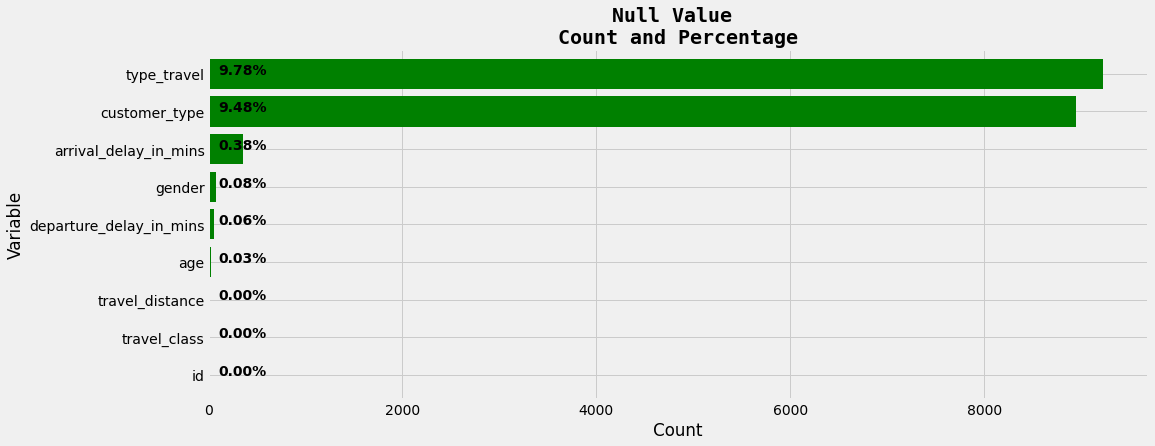

In [23]:
null_viz();

### Univariate

In [24]:
CAT_COL = train_travel.select_dtypes(exclude=np.number).columns.tolist()
NUM_COL = train_travel.select_dtypes(include=np.number).columns.tolist()[1:]

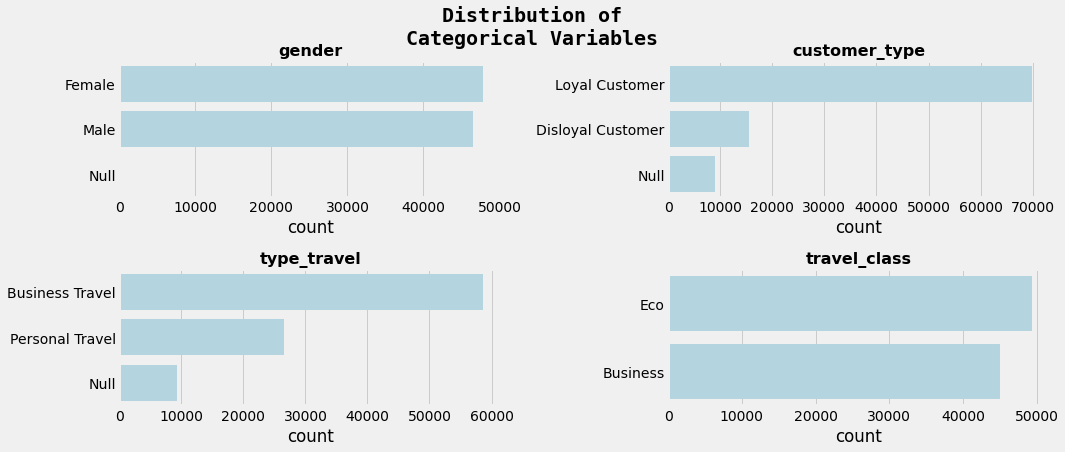

In [25]:
cat_distribution();

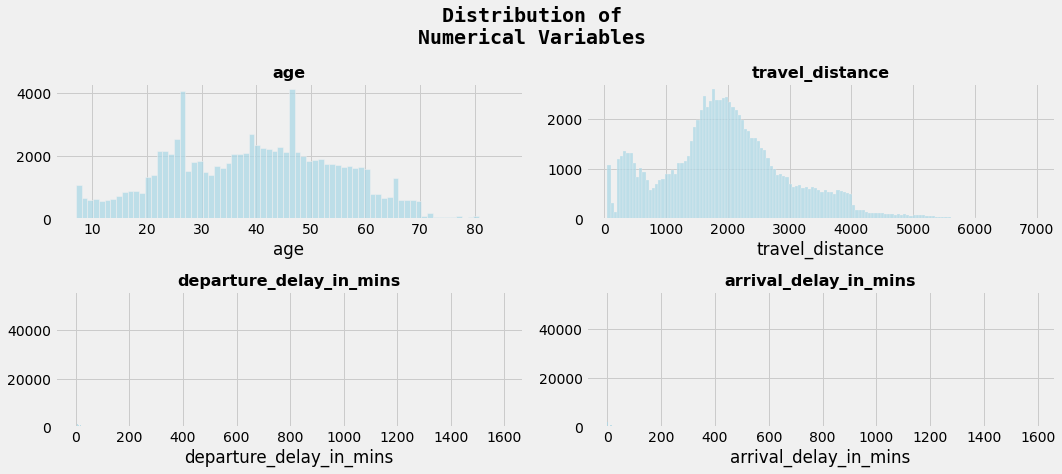

In [26]:
num_distribution();

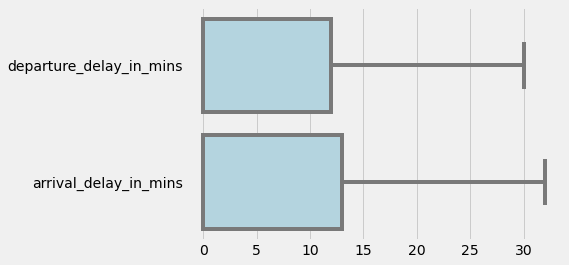

In [27]:
sns.boxplot(
    data = train_travel[['departure_delay_in_mins', 'arrival_delay_in_mins']],
    orient = 'h',
    color = 'lightblue',
    showfliers = False
)

#### Observation

- Categorical
  - Gender and travel class are relatively evenly distributed
  - Customer type and travel type are imbalanced
- Numerical
  - There are spikes in age around 26 and 46 years old passengers. Without the spike, the distribution is almost bell shaped
  - Travel distance has a bimodal distribution, around 500 and 2000 distances
  - Delay, both in departure and arrival seems to have an outliers. The distribution is very spread out as suggested by the statistics (`.describe()`)

### Multivariate

In [28]:
plot_table = train_travel.fillna("Null")

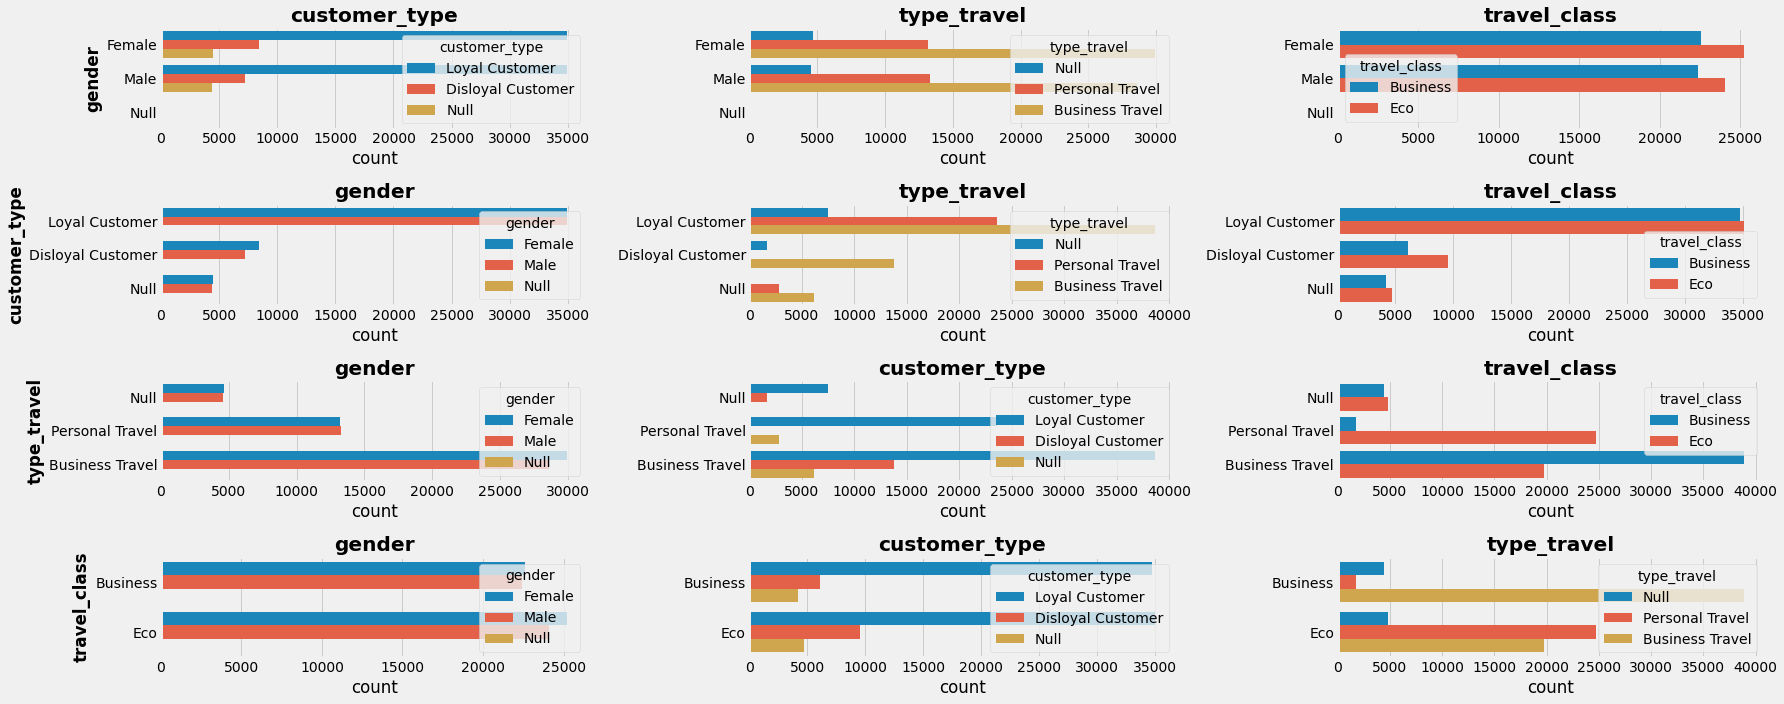

In [29]:
fig, ax = plt.subplots(4,3,figsize = (25,10));

ax_start = 0

for var in CAT_COL:  
  TEMP_LIST = CAT_COL.copy()
  TEMP_LIST.pop(TEMP_LIST.index(var))

  ax_end = ax_start+3

  for col, axs in zip(TEMP_LIST, ax.flatten()[ax_start:ax_end]):
    cnt = sns.countplot(
        data = plot_table, 
        y = var, 
        hue = col,
        ax = axs
        )
    
    if ax_start%3 == 0:
      cnt.set_ylabel(var, fontweight = 'bold')
    else:
      cnt.set_ylabel('')
    
    cnt.set_title(col, fontweight = 'bold')
    ax_start+=1

plt.tight_layout()

In [30]:
TEMP = train_travel[CAT_COL]

TEMP_TABLE = MultiColumnLabelEncoder(columns = CAT_COL).fit_transform(TEMP)

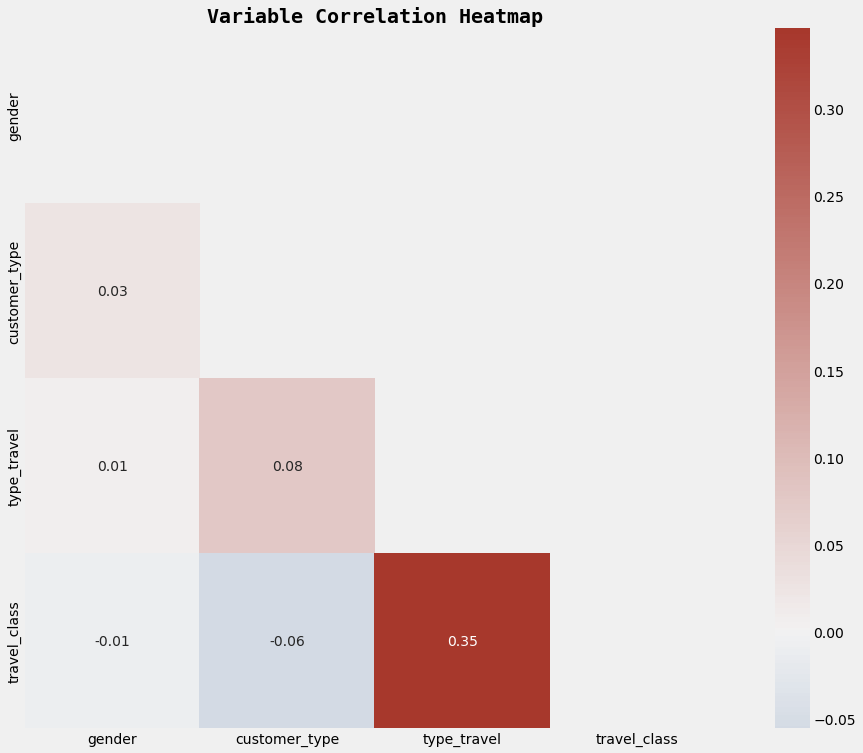

In [31]:
corr_heatmap(TEMP_TABLE);

In [32]:
# sns.pairplot(data = train_travel[NUM_COL], corner=True)

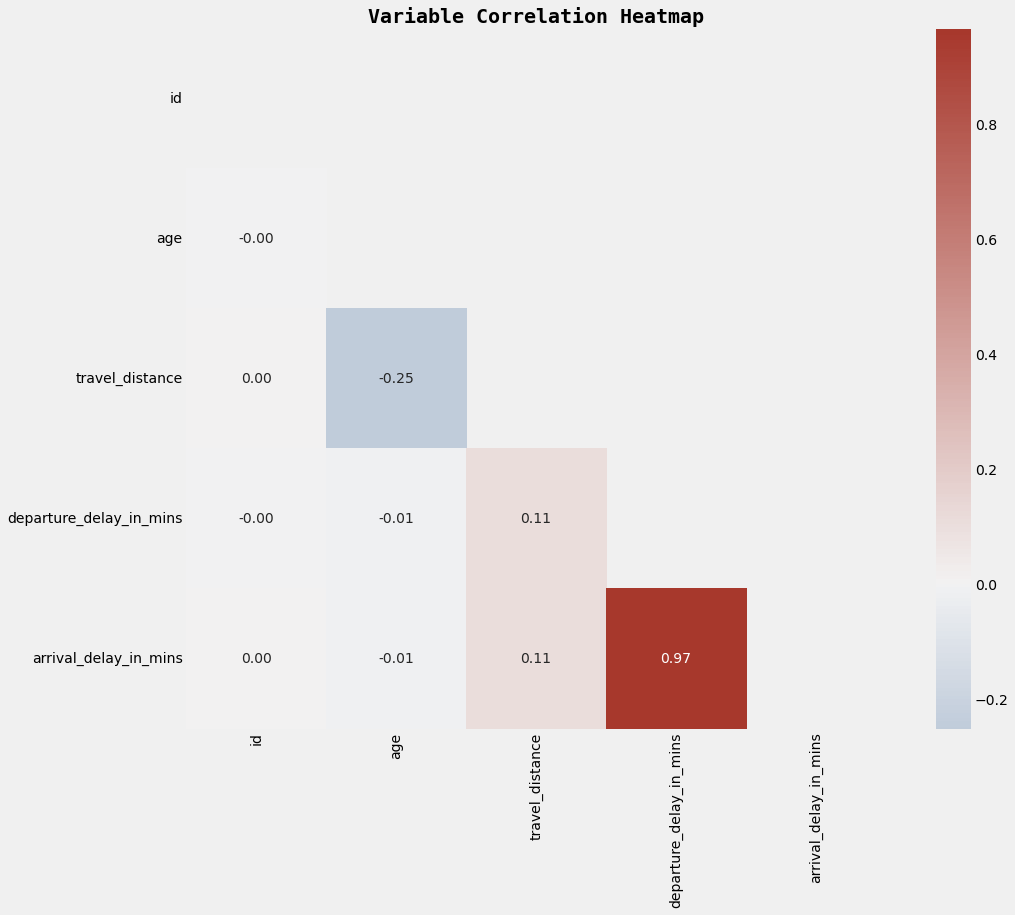

In [33]:
corr_heatmap(train_travel);

#### Observation

- Categorical
  - From the heatmap and the barplot, there are no strong correlation between categorical variables

- Numerical
  - From the heatmap and the pairplot, we see that departure and arrival delay have a strong correlation, almost completely linear with `0.97` correlation score.

## Survey

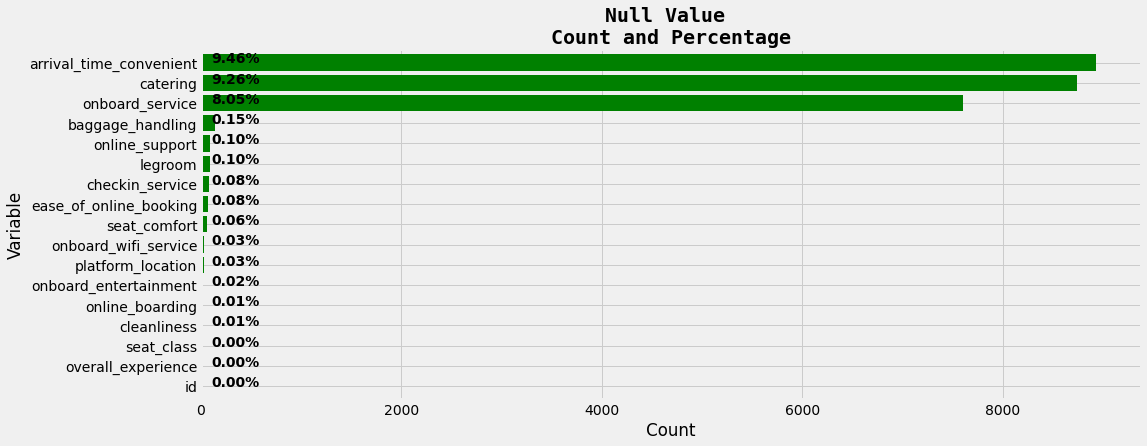

In [34]:
# check null value distribution
null_viz(train_survey);

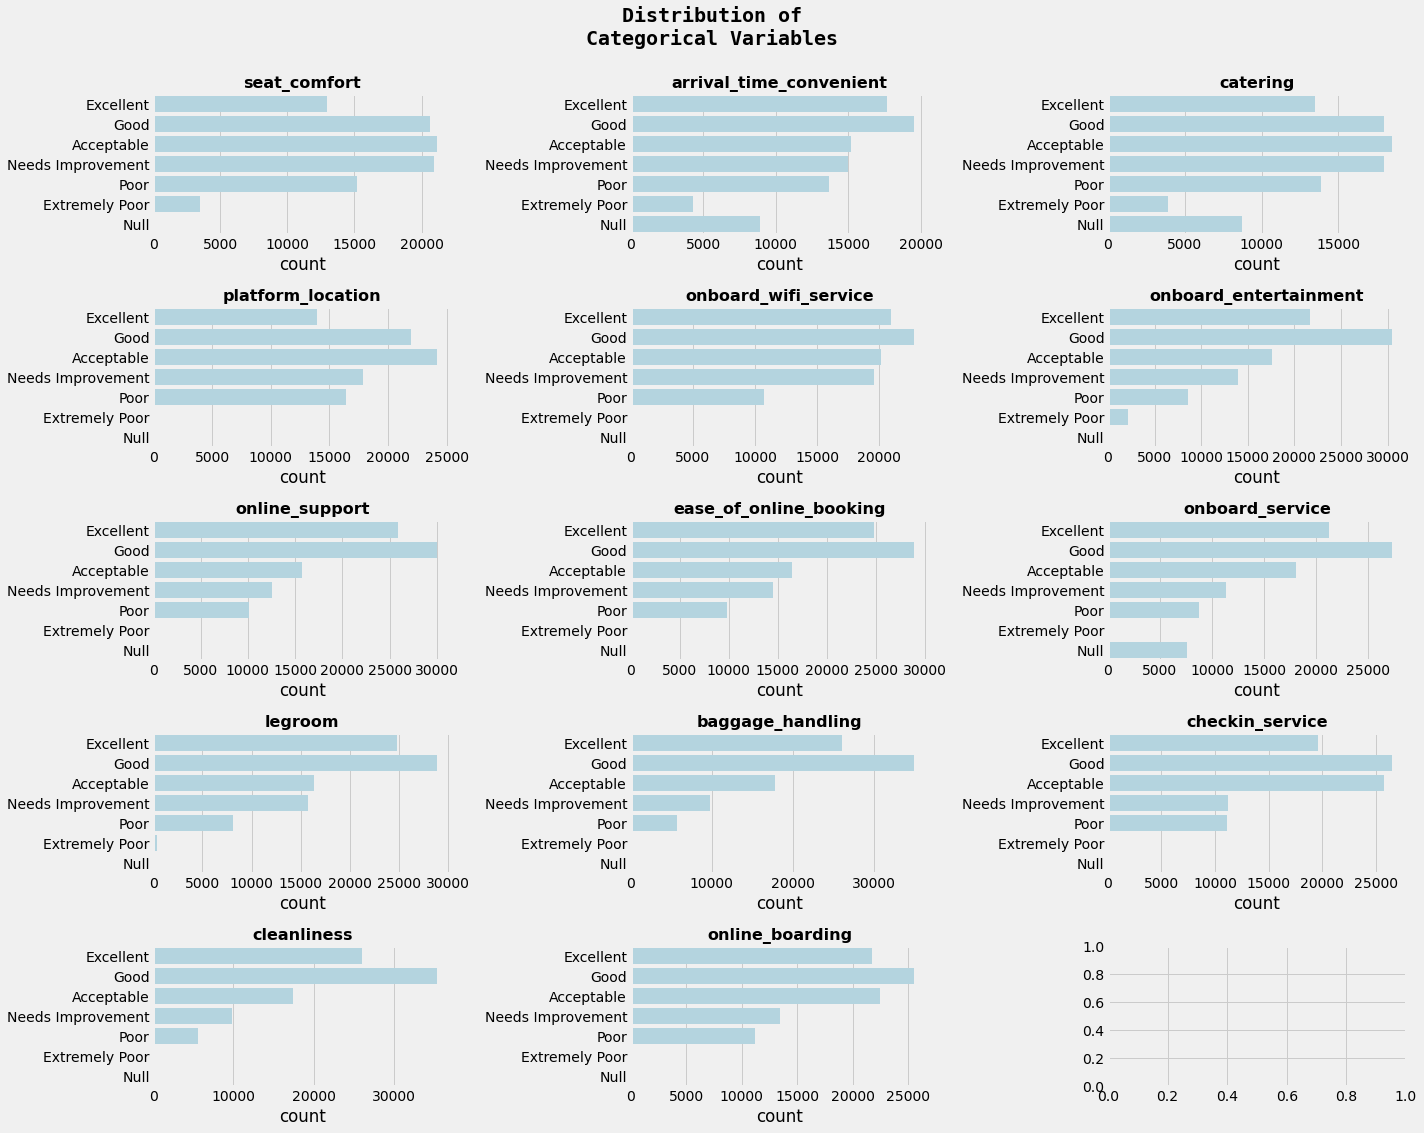

In [35]:
cat_distribution(data = train_survey.drop('seat_class', axis = 1), ncols=3, nrows=5, width = 20, height = 15, val_order = 'x');

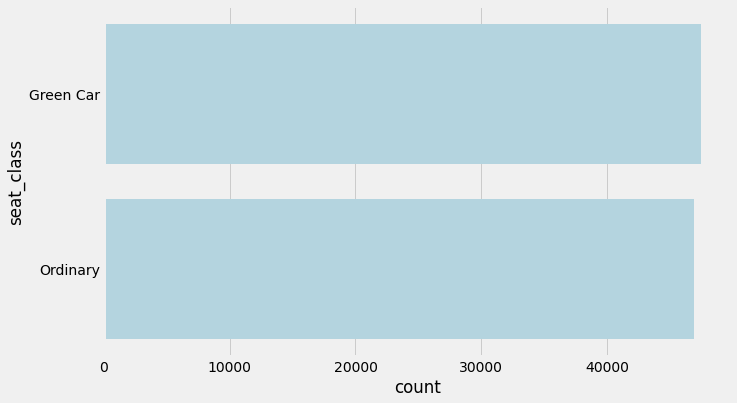

In [36]:
fig, ax = plt.subplots(figsize = (10,6))

sns.countplot(
    data = train_survey,
    y = 'seat_class',
    ax = ax,
    color = 'lightblue'
)

In [37]:
# Defining the stacked_barplot() function
def stacked_barplot(data,predictor,target = "booking_status",figsize=(10,6)):
  (pd.crosstab(data[predictor],data[target],normalize='index')*100).plot(kind='bar',figsize=figsize,stacked=True, color = ['lightblue', 'red'])
  plt.legend(loc="lower right")
  plt.ylabel('Percentage Cancellations %')

In [38]:
(pd.crosstab(train_survey['seat_comfort'],train_survey['overall_experience'],normalize='index')*100).reindex([1,0], axis = 1)

overall_experience,1,0
seat_comfort,,
Acceptable,35.395595,64.604405
Excellent,99.259887,0.740113
Extremely Poor,99.768986,0.231014
Good,65.132314,34.867686
Needs Improvement,35.720424,64.279576
Poor,45.083964,54.916036


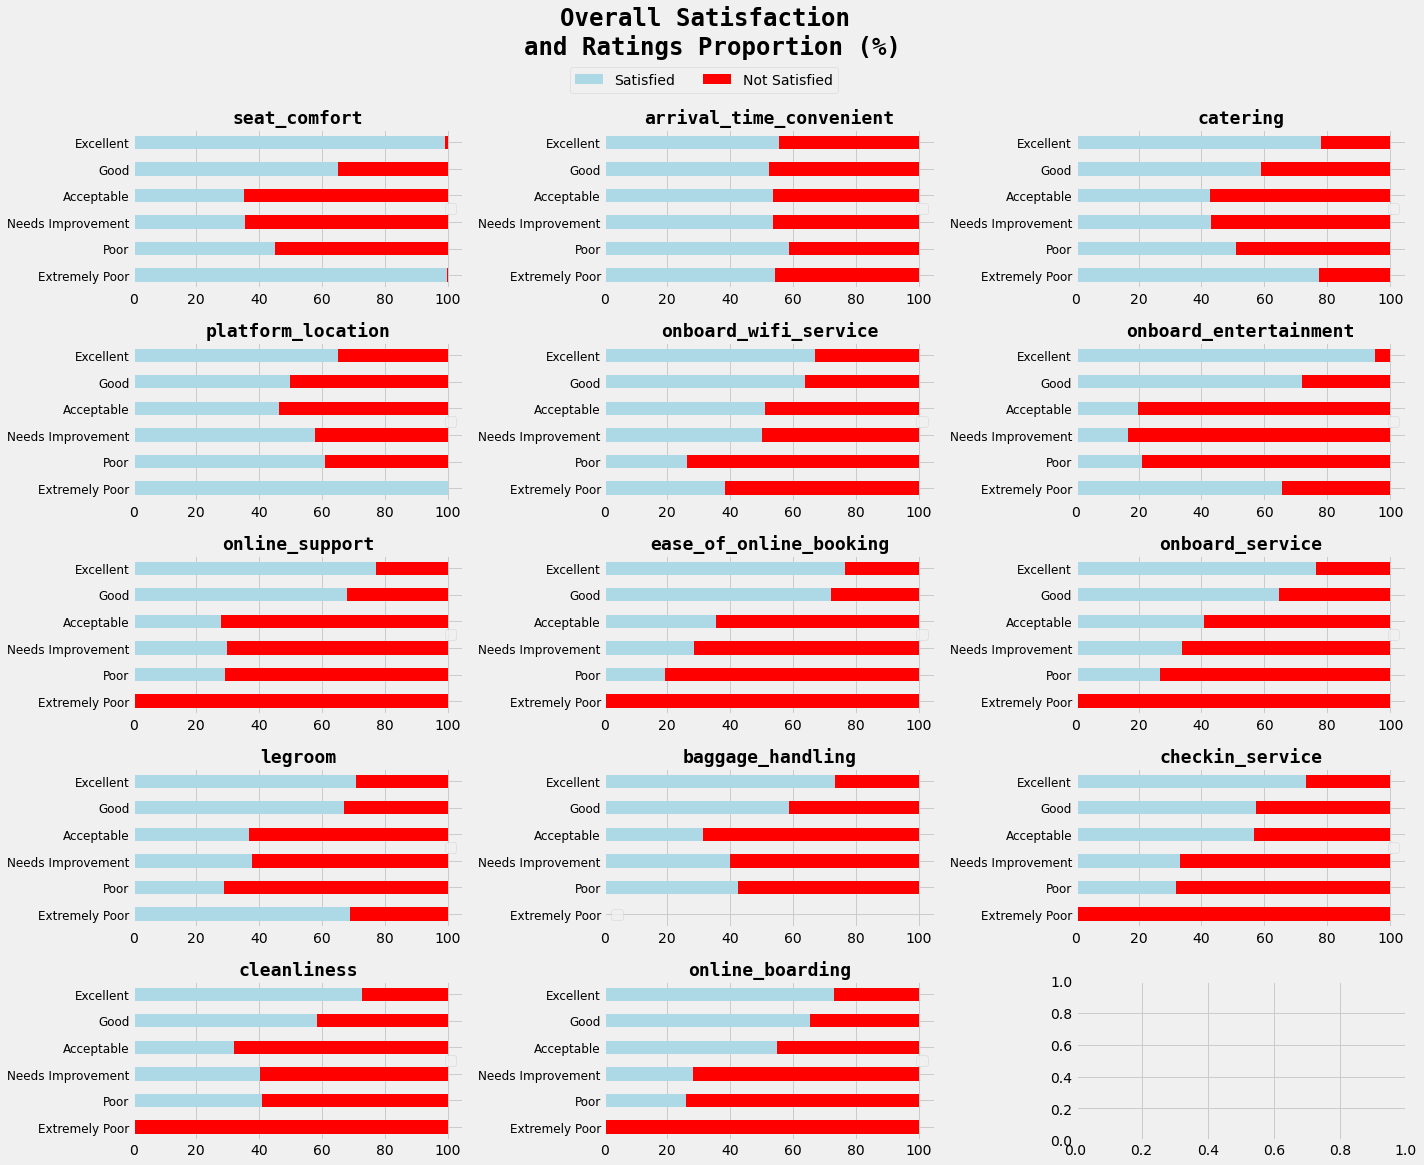

In [39]:
fig, ax = plt.subplots(5,3, figsize = (20,15))

for col, axs in zip(train_survey.drop('seat_class', axis = 1).columns[2:], ax.flatten()):
  (
      (pd.crosstab(train_survey[col],train_survey['overall_experience'],normalize='index')*100)
      .reindex(correct_val).reindex([1,0], axis = 1)
      .plot.barh(ax = axs,stacked=True, color = ['lightblue', 'red'])
  )

  axs.legend('')
  axs.set_ylabel('')
  axs.set_yticklabels(labels = correct_val, fontsize = 12)
  axs.set_title(col, fontweight = 'bold', fontfamily = 'monospace', fontsize = 18)

plt.suptitle("Overall Satisfaction \nand Ratings Proportion (%)", fontweight = 'bold', fontfamily = 'monospace', fontsize = 24, y = 1.08)
handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, ['Satisfied', 'Not Satisfied'], loc=(0.4,0.92), ncol=2)
plt.tight_layout()

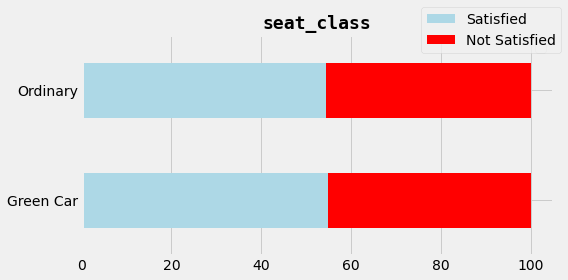

In [40]:
fig, ax = plt.subplots(figsize = (8,4))

(
    (pd.crosstab(train_survey['seat_class'],train_survey['overall_experience'],normalize='index')*100)
    .reindex([1,0], axis = 1)
    .plot.barh(ax = ax,stacked=True, color = ['lightblue','red'])
)

ax.legend('')
ax.set_ylabel('')
ax.set_title('seat_class', fontweight = 'bold', fontfamily = 'monospace', fontsize = 18)

handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, ['Satisfied', 'Not Satisfied'], loc='upper right')

plt.tight_layout()

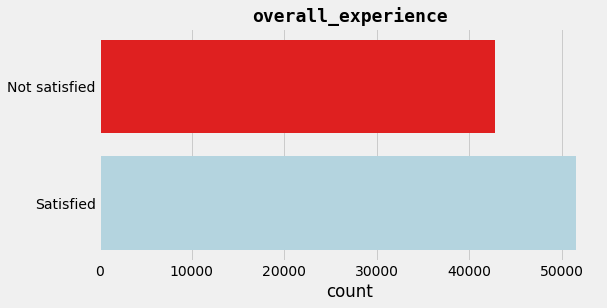

In [41]:
fig, ax = plt.subplots(figsize = (8,4))

sns.countplot(
    data = train_survey,
    y = 'overall_experience',
    ax = ax,
    palette=['lightblue','red'][::-1],
)

ax.set_ylabel('');
ax.set_title('overall_experience', fontweight = 'bold', fontfamily = 'monospace', fontsize = 18);
ax.set_yticklabels(['Not satisfied', 'Satisfied']);

In [42]:
TEMP_SURVEY = train_survey.copy()

label_val = [0,1,2,3,4,5]

LABEL_MAP = dict(zip(correct_val, label_val))

for i in TEMP_SURVEY.drop(columns = 'seat_class').columns[2:]:
  TEMP_SURVEY[i] = TEMP_SURVEY[i].map(LABEL_MAP)
  TEMP_SURVEY[i] = TEMP_SURVEY[i].astype('Int64')

In [43]:
TEMP_SURVEY.head()

,id,overall_experience,seat_comfort,seat_class,arrival_time_convenient,catering,platform_location,onboard_wifi_service,onboard_entertainment,online_support,ease_of_online_booking,onboard_service,legroom,baggage_handling,checkin_service,cleanliness,online_boarding
0,98800001,0,2,Green Car,5,5,5,4,2,3,2,2,3,2,4,2,1
1,98800002,0,1,Ordinary,5,1,2,4,1,4,4,5,2,1,2,4,4
2,98800003,1,2,Green Car,2,2,2,2,4,5,5,5,5,5,4,5,5
3,98800004,0,3,Ordinary,2,<NA>,2,3,2,3,3,3,3,3,4,3,3
4,98800005,1,3,Ordinary,3,3,3,2,4,5,4,4,4,4,4,4,4


In [44]:
# sns.pairplot(data = TEMP_SURVEY.drop(columns = ['id']), hue = 'overall_experience', corner=True)

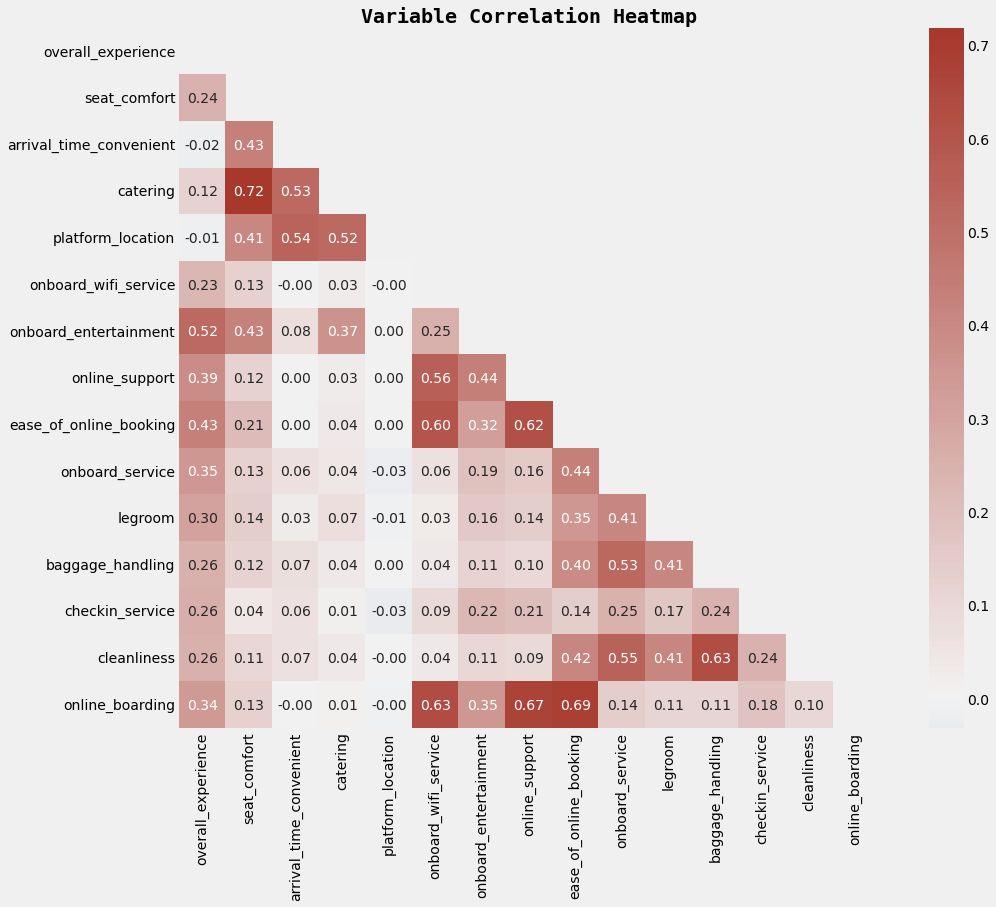

In [45]:
corr_heatmap(TEMP_SURVEY.drop(columns = ['id']));

# DATA ENGINEERING

- (Optional) Check the union of id from both table, then merge table
- Travel columns
  - Null values
    - `age`, `gender` - mode
    - `arrival_delay` - try using linear regression from `departure_delay`
    - `departure_delay` - drop
    - `customer_type` - fill with "disloyal"
    - `type_travel` - if class == eco then personal, else business
  - Outliers
    - `delay` use z score
  - Scaler/normalize/standardize `age`, `distance`, `delay`
  - OHE `gender`, `type_travel`
  - Label encode `customer_type`, `travel_class`
  - Drop `id` -- unimportant
  - Drop one of the `delay` -- strong correlation
- Survey columns
  - Null values - mode or just drop
  - OHE `seat_class`
  - Label encode everything else
- Continue with PCA (check variability)

In [46]:
# check id matchness between travel and survey
pd.Series(train_travel.id == train_survey.id).unique()

array([ True])

## Travel

Except for the `Drop null and ouliers` part, the function below have replaced the commented data engineering process

In [47]:
def data_engineering_travel(lazyframe = train_travel_pl):
  ''' 
  This function DOES
    - rename columns
    - fix data type
    - fill null values
    - scaling
    - encoding
  
  This function DOES NOT
    - drop any initial columns
    - remove outliers
  '''
  # rename columns
  COLUMN_MAPPING = {col:col.lower() for col in lazyframe.columns}
  lazyframe = lazyframe.rename(COLUMN_MAPPING)

  # change data type
  lazyframe = lazyframe.with_column(
      pl.col([
          "id",
          "age",
          "travel_distance",
          "departure_delay_in_mins",
          "arrival_delay_in_mins",
          ]).cast(pl.Int64, strict=False)
  )

  # fill null values
  lazyframe = lazyframe.with_columns([
      pl.col("age").fill_null(pl.col("age").mode()),
      pl.col("gender").fill_null(pl.col("gender").mode()),
      pl.col("customer_type").fill_null(pl.lit("Disloyal Customer")),
      pl.col("type_travel").fill_null(pl.when(pl.col("travel_class") == "Eco").then(pl.lit("Personal Travel")).otherwise(pl.lit("Business Travel"))),
  ])

  # prepare a dataframe to be plot as a comparison before applying the scaler
  before_scale = lazyframe.select([
      pl.col('age'),
      pl.col('travel_distance'),
      pl.col('departure_delay_in_mins'),
      pl.col('arrival_delay_in_mins'),
  ]).collect()

  scaler = MinMaxScaler()

  after_scale_pd = before_scale.to_pandas()

  scaled_col = [i+'_scaled' for i in before_scale.columns]

  after_scale_pd[scaled_col] = scaler.fit_transform(after_scale_pd)
  after_scale_pd = after_scale_pd[scaled_col]

  # prepare a dataframe to be plot as a comparison before applying the encoder
  before_encode = lazyframe.select([
      pl.col("gender"),
      pl.col("type_travel"),
      pl.col("customer_type"),
      pl.col("travel_class")
  ]).collect()

  # get the one hot encoded values

  OHE = pd.get_dummies(before_encode.to_pandas().iloc[:,:2])

  num_val = [0,1]

  cust_type_val = ["Disloyal Customer", "Loyal Customer"]
  travel_class_val = ["Eco", "Business"]

  CUST_TYPE_MAP = dict(zip(cust_type_val, num_val))
  TRAVEL_CLASS_MAP = dict(zip(travel_class_val, num_val))

  label_encode = before_encode.to_pandas()

  # Label encode the ordinal value

  label_encode['customer_type_enc'] = label_encode['customer_type'].map(CUST_TYPE_MAP)
  label_encode['type_class_enc'] = label_encode['travel_class'].map(TRAVEL_CLASS_MAP)

  label_encode = label_encode.iloc[:,-2:]
  after_encode = pd.merge(label_encode, OHE, left_index=True, right_index=True)

  df_final = pd.merge(after_scale_pd, after_encode, left_index=True, right_index=True)
  df_final = pd.merge(lazyframe.collect().to_pandas()[['id']], df_final, left_index=True, right_index=True)
  return df_final

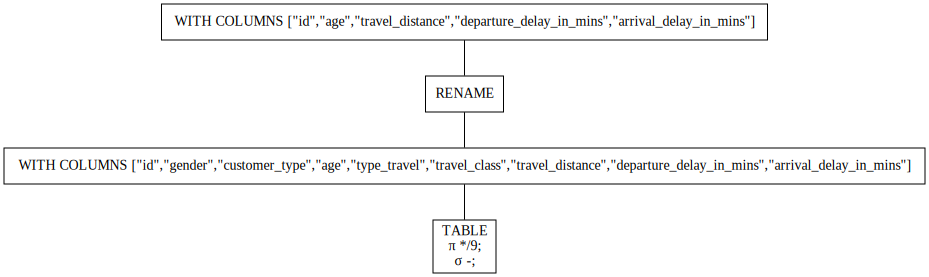

In [48]:
# checking changes made so far
train_travel_pl.show_graph()

In [49]:
train_travel_pl.head(3).collect()

id,gender,customer_type,age,type_travel,travel_class,travel_distance,departure_delay_in_mins,arrival_delay_in_mins
i64,str,str,i64,str,str,i64,i64,i64
98800001,"""Female""","""Loyal Customer...",52,null,"""Business""",272,0,5
98800002,"""Male""","""Loyal Customer...",48,"""Personal Trave...","""Eco""",2200,9,0
98800003,"""Female""","""Loyal Customer...",43,"""Business Trave...","""Business""",1061,77,119


In [50]:
# copy the lazyframe

train_travel_pl_clone = train_travel_pl.clone()

### Fill null values

In [51]:
# # fill null values

# train_travel_pl_clone = train_travel_pl_clone.with_columns([
#     pl.col("age").fill_null(pl.col("age").mode()),
#     pl.col("gender").fill_null(pl.col("gender").mode()),
#     pl.col("customer_type").fill_null(pl.lit("Disloyal Customer")),
#     pl.col("type_travel").fill_null(pl.when(pl.col("travel_class") == "Eco").then(pl.lit("Personal Travel")).otherwise(pl.lit("Business Travel"))),
# ])

### Drop null and outliers

In [52]:
# # calculating zscore for depart delay in mins

# depart_series = train_travel_pl_clone.select(
#     pl.col("arrival_delay_in_mins")
#     ).collect().to_pandas()["arrival_delay_in_mins"]

# depart_zscore = np.abs(stats.zscore(
#     depart_series,nan_policy='omit'
#     )
# )

# train_travel_pl_clone = train_travel_pl_clone.with_column(
#     pl.Series(name="depart_zscore", values=depart_zscore)
# )

In [53]:
# # drop null values and outliers

# train_travel_pl_clone = train_travel_pl_clone.filter(
#     (~pl.col("arrival_delay_in_mins").is_null())
#     & (pl.col("depart_zscore") < 3)
# )

In [54]:
# # double check null values
# train_travel_pl_clone.collect().null_count()

In [55]:
# train_travel_pl_clone.collect().shape

### Standardize the values

Using min max scaler

In [56]:
# # prepare a dataframe to be plot as a comparison before applying the scaler
# before_scale = train_travel_pl_clone.select([
#     pl.col('age'),
#     pl.col('travel_distance'),
#     pl.col('departure_delay_in_mins'),
#     pl.col('arrival_delay_in_mins'),
# ]).collect()

In [57]:
# fig, ax = plt.subplots(1,4, figsize = (25,6))

# for i,j in zip(before_scale.columns, ax.flatten()):
#   hist = sns.histplot(
#       data = before_scale,
#       x = i,
#       ax = j
#   )

#   if i != 'age':
#     hist.set_ylabel('');

# plt.suptitle("Data distribution before scaling", fontsize = 20, fontweight = 'bold', fontfamily = 'monospace');
# plt.tight_layout;

In [58]:
# scaler = MinMaxScaler()

In [59]:
# after_scale_pd = before_scale.to_pandas()

In [60]:
# scaled_col = [i+'_scaled' for i in before_scale.columns]

# after_scale_pd[scaled_col] = scaler.fit_transform(after_scale_pd)

In [61]:
# fig, ax = plt.subplots(1,4, figsize = (25,6))

# for i,j in zip(after_scale_pd.columns[4:], ax.flatten()):
#   hist = sns.histplot(
#       data = after_scale_pd,
#       x = i,
#       ax = j
#   )

#   if i != 'age':
#     hist.set_ylabel('');

# plt.suptitle("Data distribution after scaling", fontsize = 20, fontweight = 'bold', fontfamily = 'monospace');
# plt.tight_layout;

In [62]:
# after_scale_pd = after_scale_pd[scaled_col]
# after_scale_pd

### Encoding categorical values

In [63]:
# train_travel_pl_clone.head(3).collect()

In [64]:
# before_encode = train_travel_pl_clone.select([
#     pl.col("gender"),
#     pl.col("type_travel"),
#     pl.col("customer_type"),
#     pl.col("travel_class")
# ]).collect()

In [65]:
# # get the one hot encoded values

# OHE = pd.get_dummies(before_encode.to_pandas().iloc[:,:2])

In [66]:
# num_val = [0,1]

# cust_type_val = ["Disloyal Customer", "Loyal Customer"]
# travel_class_val = ["Eco", "Business"]

# CUST_TYPE_MAP = dict(zip(cust_type_val, num_val))
# TRAVEL_CLASS_MAP = dict(zip(travel_class_val, num_val))

In [67]:
# label_encode = before_encode.to_pandas()

In [68]:
# # Label encode the ordinal value

# label_encode['customer_type_enc'] = label_encode['customer_type'].map(CUST_TYPE_MAP)
# label_encode['type_class_enc'] = label_encode['travel_class'].map(TRAVEL_CLASS_MAP)

In [69]:
# label_encode = label_encode.iloc[:,-2:]
# after_encode = pd.merge(label_encode, OHE, left_index=True, right_index=True)
# after_encode

### Merging the data

In [70]:
# train_travel_final = pd.merge(after_scale_pd, after_encode, left_index=True, right_index=True)
# train_travel_final = pd.merge(train_travel_pl_clone.collect().to_pandas()[['id']], train_travel_final, left_index=True, right_index=True)
# train_travel_final.head(3)

### Final data

In [71]:
train_travel_final = data_engineering_travel()
train_travel_final.head(3)

,id,age_scaled,travel_distance_scaled,departure_delay_in_mins_scaled,arrival_delay_in_mins_scaled,customer_type_enc,type_class_enc,gender_Female,gender_Male,type_travel_Business Travel,type_travel_Personal Travel
0,98800001,0.576923,0.032169,0.000000,0.003157,1,1,1,0,1,0
1,98800002,0.525641,0.311549,0.005653,0.000000,1,0,0,1,0,1
2,98800003,0.461538,0.146501,0.048367,0.075126,1,1,1,0,1,0


In [72]:
train_travel_final.shape

(94379, 11)

## Survey

In [73]:
# https://stackoverflow.com/questions/70968749/pandas-replace-equivalent-in-python-polars

# function for label encoding
def replace(column, from_, to_):
    # initiate the expression with `pl.when`
    branch =  pl.when(pl.col(column) == from_[0]).then(to_[0])

    
    # for every value add a `when.then`
    for (from_value, to_value) in zip(from_, to_):
        branch = branch.when(pl.col(column) == from_value).then(to_value)

    # finish with an `otherwise`
    return branch.otherwise(pl.col(column)).alias(column)

def data_engineering_survey(lazyframe = train_survey_pl):
  # rename columns
  COLUMN_MAPPING_SUR = {col:col.lower() for col in lazyframe.columns}
  lazyframe = lazyframe.rename(COLUMN_MAPPING_SUR)

  # fill null values
  for i in lazyframe.columns:
    lazyframe = lazyframe.with_columns([
        pl.col(i).fill_null(pl.col(i).mode())
    ])

  # label encode all columns except "seat_class","id","overall_experience"
  lazyframe = lazyframe.with_column(replace("platform_location", odd_val, encoded_val))

  for i in lazyframe.drop(["seat_class","id","overall_experience"]).columns:
    lazyframe = lazyframe.with_column(replace(i, correct_val, encoded_val))

  # convert data types
  lazyframe = lazyframe.with_column(
      pl.col('id').cast(pl.Int64, strict=False)
  )

  lazyframe = lazyframe.with_column(
      pl.col(lazyframe.drop(["id","seat_class"]).columns).cast(pl.UInt8, strict=False)
  )

  # one hot encode "seat_class" and materialize the dataframe
  train_survey_final = pl.get_dummies(lazyframe.collect(), columns = ['seat_class'])
  return train_survey_final.to_pandas()

In [74]:
# checking changes made so far
# train_survey_pl.show_graph()

In [75]:
# # rename columns

# COLUMN_MAPPING_SUR = {col:col.lower() for col in train_survey_pl.columns}
# train_survey_pl = train_survey_pl.rename(COLUMN_MAPPING_SUR)

### Fill null values

In [76]:
# # fill null values
# for i in train_survey_pl.columns:
#   train_survey_pl = train_survey_pl.with_columns([
#       pl.col(i).fill_null(pl.col(i).mode())
#   ])

### Encode all values

In [77]:
# # https://stackoverflow.com/questions/70968749/pandas-replace-equivalent-in-python-polars

# def replace(column, from_, to_):
#     # initiate the expression with `pl.when`
#     branch =  pl.when(pl.col(column) == from_[0]).then(to_[0])

    
#     # for every value add a `when.then`
#     for (from_value, to_value) in zip(from_, to_):
#         branch = branch.when(pl.col(column) == from_value).then(to_value)

#     # finish with an `otherwise`
#     return branch.otherwise(pl.col(column)).alias(column)

In [78]:
# # label encode all columns except "seat_class","id","overall_experience"
# train_survey_pl = train_survey_pl.with_column(replace("platform_location", odd_val, encoded_val))

# for i in train_survey_pl.drop(["seat_class","id","overall_experience"]).columns:
#   train_survey_pl = train_survey_pl.with_column(replace(i, correct_val, encoded_val))

In [79]:
# # convert data types
# train_survey_pl = train_survey_pl.with_column(
#     pl.col('id').cast(pl.Int64, strict=False)
# )

# train_survey_pl = train_survey_pl.with_column(
#     pl.col(train_survey_pl.drop(["id","seat_class"]).columns).cast(pl.UInt8, strict=False)
# )

In [80]:
# # one hot encode "seat_class" and materialize the dataframe

# train_survey_final = pl.get_dummies(train_survey_pl.collect(), columns = ['seat_class'])

In [81]:
# train_survey_final.head(3)

### Final data

In [82]:
train_survey_final = data_engineering_survey()

## Combined data

In [83]:
df_combined = pd.merge(train_travel_final, train_survey_final, on = 'id')
df_combined.shape

(94379, 28)

In [84]:
df_combined.isna().sum()

id                                  0
age_scaled                          0
travel_distance_scaled              0
departure_delay_in_mins_scaled     57
arrival_delay_in_mins_scaled      357
customer_type_enc                   0
type_class_enc                      0
gender_Female                       0
gender_Male                         0
type_travel_Business Travel         0
type_travel_Personal Travel         0
overall_experience                  0
seat_comfort                        0
seat_class_Green Car                0
seat_class_Ordinary                 0
arrival_time_convenient             0
catering                            0
platform_location                   0
onboard_wifi_service                0
onboard_entertainment               0
online_support                      0
ease_of_online_booking              0
onboard_service                     0
legroom                             0
baggage_handling                    0
checkin_service                     0
cleanliness 

In [85]:
df_combined = df_combined[(
    np.abs(stats.zscore(df_combined["arrival_delay_in_mins_scaled"], nan_policy='omit')) < 3
    )]

(<Figure size 576x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f43752e7810>)

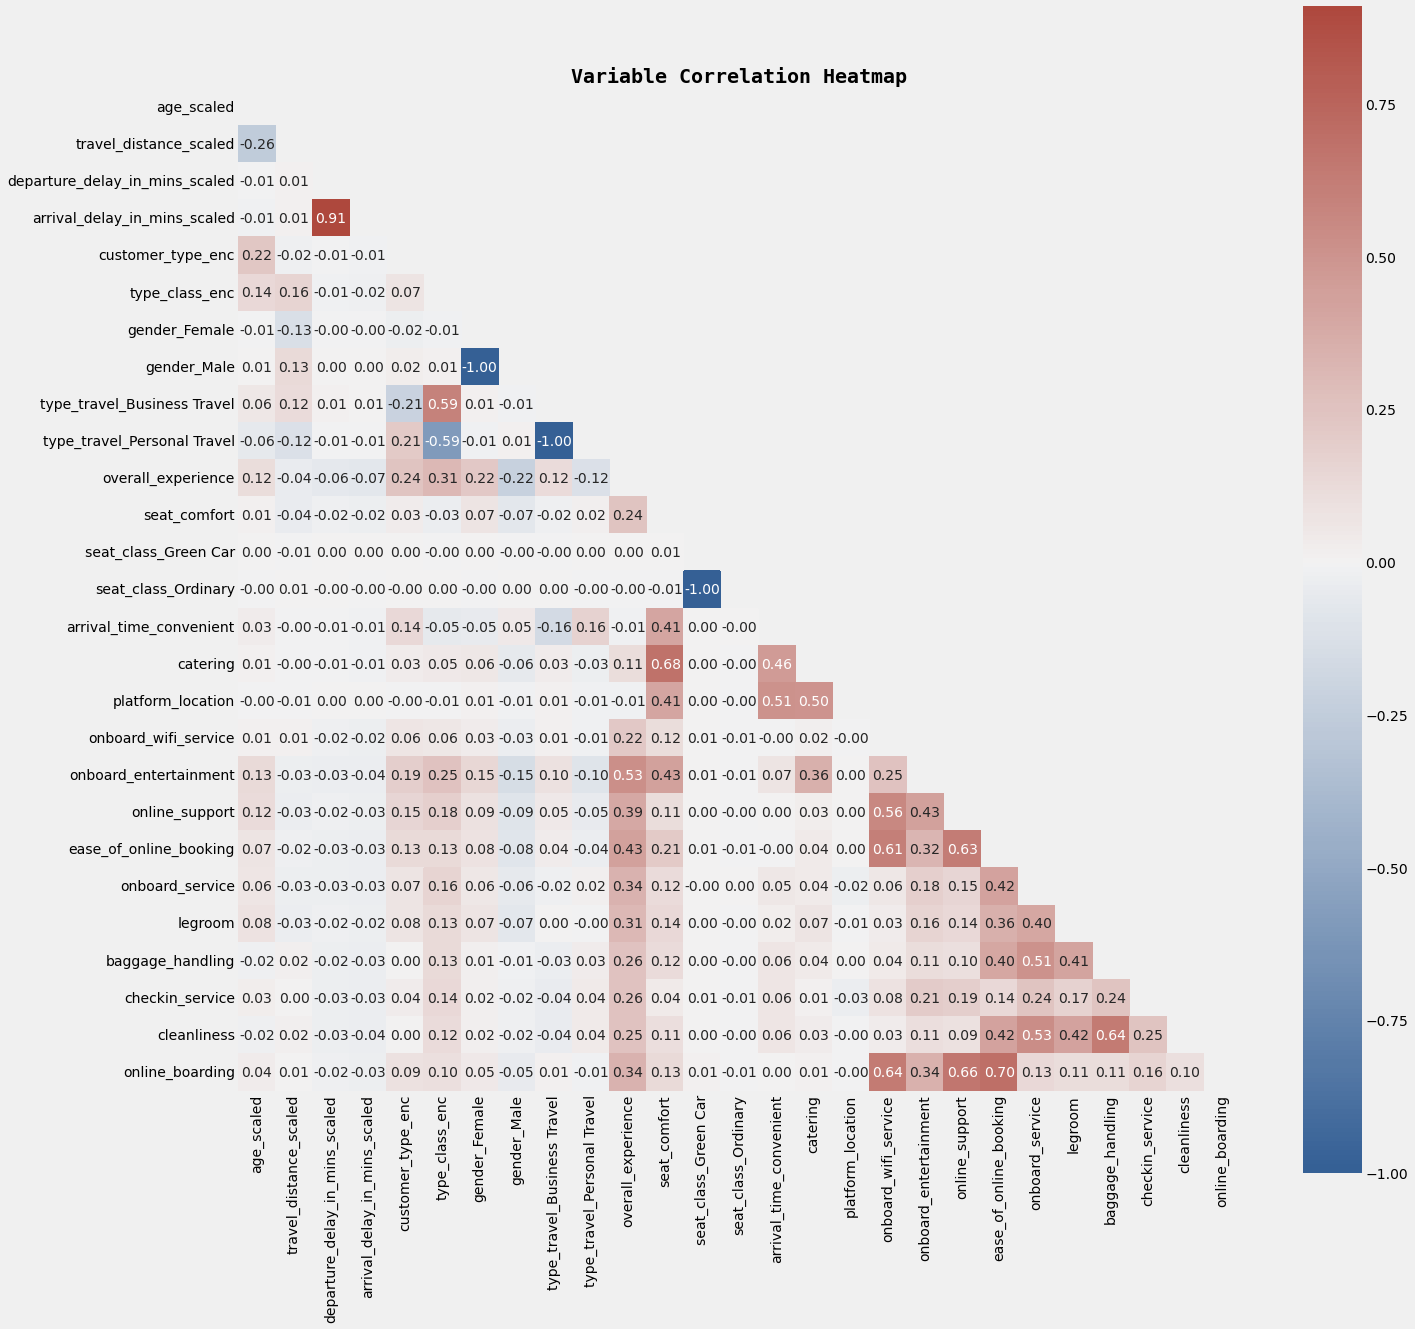

In [86]:
corr_heatmap(df_combined.iloc[:,1:], width = 20, height = 20)

# MACHINE LEARNING

In [87]:
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV

from sklearn.linear_model import LogisticRegression

# Metrics to evaluate the model
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, recall_score, roc_curve, auc, accuracy_score

In [88]:
# Creating metric function 
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))

    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Satisfied', 'Satisfied'], yticklabels=['Not Satisfied', 'Satisfied'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

## Data Preparation



### Travel only

In [89]:
# get the target value accordingly

df_travel = pd.merge(train_travel_final, train_survey[['id','overall_experience']], on = 'id')
df_travel = df_travel.drop(columns = ['arrival_delay_in_mins_scaled', 'gender_Female','type_travel_Business Travel']) # drop one of the delay column to prevent multicollinearity

df_travel = df_travel[(
    np.abs(stats.zscore(df_travel["departure_delay_in_mins_scaled"], nan_policy='omit')) < 3
    )]

df_travel.head(3)

,id,age_scaled,travel_distance_scaled,departure_delay_in_mins_scaled,customer_type_enc,type_class_enc,gender_Male,type_travel_Personal Travel,overall_experience
0,98800001,0.576923,0.032169,0.000000,1,1,0,0,0
1,98800002,0.525641,0.311549,0.005653,1,0,1,1,0
2,98800003,0.461538,0.146501,0.048367,1,1,0,0,1


In [90]:
X = df_travel.iloc[:,1:-1]
Y = df_travel['overall_experience']

In [91]:
# Splitting the data
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size = 0.3, random_state = 1)

### Combined

In [92]:
df_combined.head(3)

,id,age_scaled,travel_distance_scaled,departure_delay_in_mins_scaled,arrival_delay_in_mins_scaled,customer_type_enc,type_class_enc,gender_Female,gender_Male,type_travel_Business Travel,...,onboard_wifi_service,onboard_entertainment,online_support,ease_of_online_booking,onboard_service,legroom,baggage_handling,checkin_service,cleanliness,online_boarding
0,98800001,0.576923,0.032169,0.000000,0.003157,1,1,1,0,1,...,4,2,3,2,2,3,2,4,2,1
1,98800002,0.525641,0.311549,0.005653,0.000000,1,0,0,1,0,...,4,1,4,4,5,2,1,2,4,4
2,98800003,0.461538,0.146501,0.048367,0.075126,1,1,1,0,1,...,2,4,5,5,5,5,5,4,5,5


In [93]:
df_combined.columns

Index(['id', 'age_scaled', 'travel_distance_scaled',
       'departure_delay_in_mins_scaled', 'arrival_delay_in_mins_scaled',
       'customer_type_enc', 'type_class_enc', 'gender_Female', 'gender_Male',
       'type_travel_Business Travel', 'type_travel_Personal Travel',
       'overall_experience', 'seat_comfort', 'seat_class_Green Car',
       'seat_class_Ordinary', 'arrival_time_convenient', 'catering',
       'platform_location', 'onboard_wifi_service', 'onboard_entertainment',
       'online_support', 'ease_of_online_booking', 'onboard_service',
       'legroom', 'baggage_handling', 'checkin_service', 'cleanliness',
       'online_boarding'],
      dtype='object')

In [94]:
Y_com = df_combined['overall_experience']
X_com = df_combined.drop(columns = ['id','overall_experience', 'arrival_delay_in_mins_scaled', 'gender_Male', 'type_travel_Business Travel', 'seat_class_Ordinary'])

In [95]:
# Splitting the data
X_train_com, X_val_com, y_train_com, y_val_com = train_test_split(X_com, Y_com, test_size = 0.3, random_state = 1)

## Logistic regression

### Travel Only

In [96]:
# Fitting logistic regression model
lg=LogisticRegression()
lg.fit(X_train, y_train)

LogisticRegression()

              precision    recall  f1-score   support

           0       0.74      0.65      0.69     29209
           1       0.74      0.81      0.77     35454

    accuracy                           0.74     64663
   macro avg       0.74      0.73      0.73     64663
weighted avg       0.74      0.74      0.74     64663



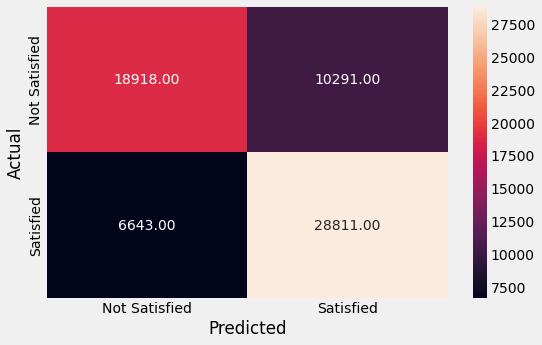

In [97]:
# Checking the performance on the training data
y_pred_train = lg.predict(X_train)

metrics_score(y_train, y_pred_train)

              precision    recall  f1-score   support

           0       0.73      0.64      0.68     12308
           1       0.74      0.81      0.77     15406

    accuracy                           0.74     27714
   macro avg       0.74      0.73      0.73     27714
weighted avg       0.74      0.74      0.73     27714



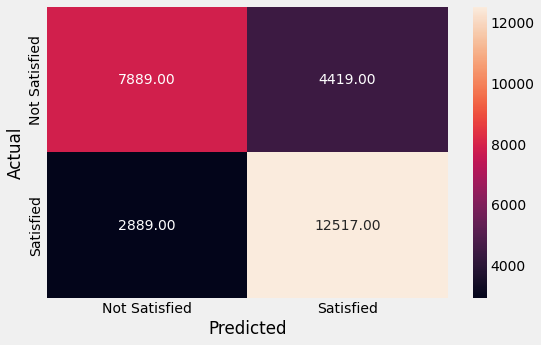

In [98]:
# Checking the performance on the val dataset
y_pred_val = lg.predict(X_val)

metrics_score(y_val, y_pred_val)

In [99]:
# Printing the coefficients of logistic regression
cols=X.columns

coef_lg=lg.coef_

temp = pd.DataFrame(coef_lg,columns=cols).T.sort_values(by = 0,ascending = False).rename(columns = {0:'coef'})
temp['odds'] = np.exp(temp['coef'])

temp

,coef,odds
type_class_enc,1.446447,4.247993
customer_type_enc,1.208452,3.348297
age_scaled,0.176084,1.192539
type_travel_Personal Travel,0.039810,1.040613
travel_distance_scaled,-0.873177,0.417623
gender_Male,-1.076951,0.340633
departure_delay_in_mins_scaled,-7.366399,0.000632


In [100]:
# Predict_proba gives the probability of each observation belonging to each class
y_scores_lg=lg.predict_proba(X_train)

precisions_lg, recalls_lg, thresholds_lg = precision_recall_curve(y_train, y_scores_lg[:,1])

In [101]:
def f1_score(precisions_lg, recalls_lg):
  return 2*((precisions_lg*recalls_lg)/(precisions_lg+recalls_lg))

In [102]:
f1_list = [[i,j,k,f1_score(i,j)] for i, j,k in zip(precisions_lg,recalls_lg,thresholds_lg)]

_ = pd.DataFrame(data = f1_list, columns = ['precision','recall','threshold','f1'])
opt_thresh = _.sort_values(by = 'f1', ascending = False).head(1)['threshold'].iloc[0]
_.sort_values(by = 'f1', ascending = False).head(1)

,precision,recall,threshold,f1
22670,0.720547,0.848564,0.378589,0.779333


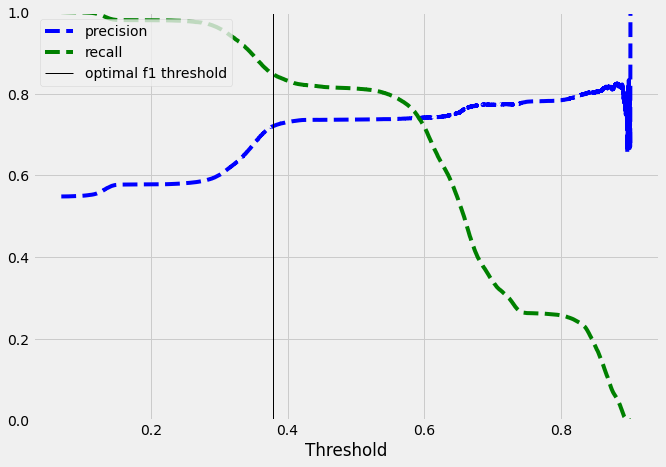

In [103]:
# Plot values of precisions, recalls, and thresholds
plt.figure(figsize=(10,7))
plt.plot(thresholds_lg, precisions_lg[:-1], 'b--', label='precision')
plt.plot(thresholds_lg, recalls_lg[:-1], 'g--', label = 'recall')
plt.axvline(x = opt_thresh, color = 'black', label = 'optimal f1 threshold', linewidth= 1)
plt.xlabel('Threshold')
plt.legend(loc='upper left')
plt.ylim([0,1])
plt.show()

              precision    recall  f1-score   support

           0       0.77      0.60      0.67     29209
           1       0.72      0.85      0.78     35454

    accuracy                           0.74     64663
   macro avg       0.74      0.72      0.73     64663
weighted avg       0.74      0.74      0.73     64663



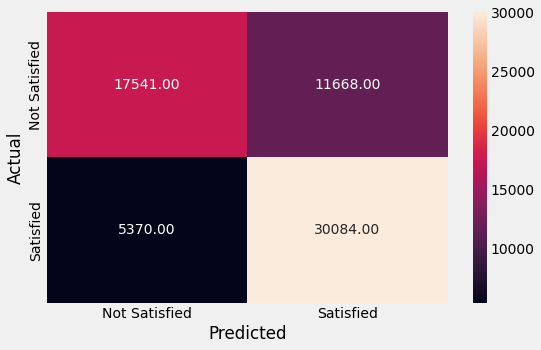

In [104]:
optimal_threshold=opt_thresh
y_pred_train = lg.predict_proba(X_train)

metrics_score(y_train, y_pred_train[:,1]>optimal_threshold)

### Combined

In [105]:
# Fitting logistic regression model
lg_com = LogisticRegression(solver='lbfgs', max_iter=1000)
lg_com.fit(X_train_com, y_train_com)

LogisticRegression(max_iter=1000)

              precision    recall  f1-score   support

           0       0.81      0.81      0.81     28814
           1       0.84      0.85      0.85     35623

    accuracy                           0.83     64437
   macro avg       0.83      0.83      0.83     64437
weighted avg       0.83      0.83      0.83     64437



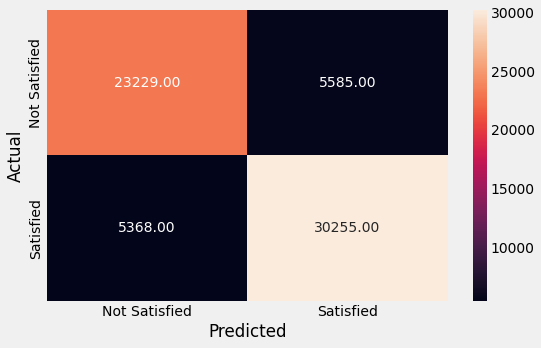

In [106]:
# Checking the performance on the training data
y_pred_train_com = lg_com.predict(X_train_com)

metrics_score(y_train_com, y_pred_train_com)

              precision    recall  f1-score   support

           0       0.82      0.81      0.81     12534
           1       0.84      0.85      0.85     15082

    accuracy                           0.83     27616
   macro avg       0.83      0.83      0.83     27616
weighted avg       0.83      0.83      0.83     27616



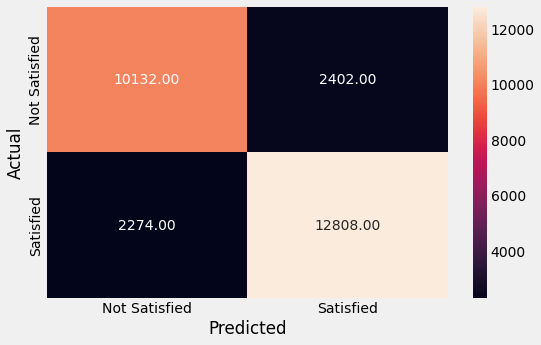

In [107]:
# Checking the performance on the val dataset
y_pred_val_com = lg_com.predict(X_val_com)

metrics_score(y_val_com, y_pred_val_com)

In [108]:
# Printing the coefficients of logistic regression
cols = X_com.columns

coef_lg_com = lg_com.coef_

temp = pd.DataFrame(coef_lg_com,columns=cols).T.sort_values(by = 0,ascending = False).rename(columns = {0:"coef"})
temp['odds'] = np.exp(temp['coef'])

temp

,coef,odds
customer_type_enc,1.169604,3.220718
gender_Female,0.948440,2.581680
type_class_enc,0.868440,2.383190
onboard_entertainment,0.748832,2.114530
ease_of_online_booking,0.348273,1.416619
onboard_service,0.277070,1.319259
checkin_service,0.264783,1.303148
seat_comfort,0.238387,1.269201
legroom,0.237789,1.268441
online_boarding,0.137289,1.147159


In [109]:
# Predict_proba gives the probability of each observation belonging to each class
y_scores_lg_com = lg_com.predict_proba(X_train_com)

precisions_lg_com, recalls_lg_com, thresholds_lg_com = precision_recall_curve(y_train_com, y_scores_lg_com[:,1])

In [110]:
f1_list = [[i,j,k,f1_score(i,j)] for i,j,k in zip(precisions_lg_com,recalls_lg_com,thresholds_lg_com)]

_ = pd.DataFrame(data = f1_list, columns = ['precision','recall','threshold','f1'])
opt_thresh = _.sort_values(by = 'f1', ascending = False).head(1)['threshold'].iloc[0]
_.sort_values(by = 'f1', ascending = False).head(1)

,precision,recall,threshold,f1
27750,0.834797,0.859332,0.475407,0.846887


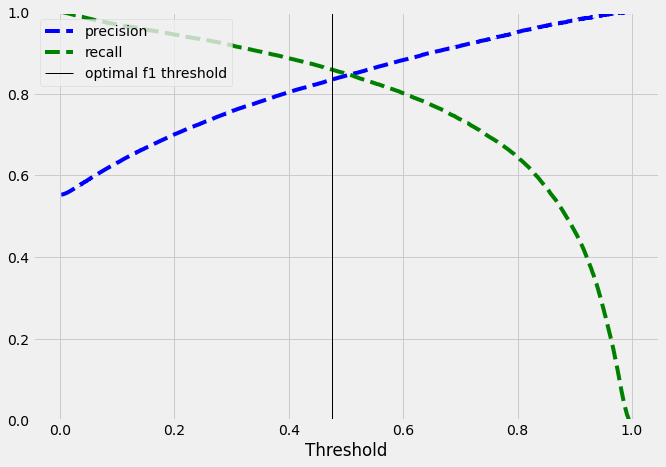

In [111]:
# Plot values of precisions, recalls, and thresholds
plt.figure(figsize=(10,7))
plt.plot(thresholds_lg_com, precisions_lg_com[:-1], 'b--', label='precision')
plt.plot(thresholds_lg_com, recalls_lg_com[:-1], 'g--', label = 'recall')
plt.axvline(x = opt_thresh, color = 'black', label = 'optimal f1 threshold', linewidth= 1)
plt.xlabel('Threshold')
plt.legend(loc='upper left')
plt.ylim([0,1])
plt.show()

## XGBoost

### Travel only

In [112]:
import xgboost as xgb
from xgboost import plot_importance

In [113]:
# XGB baseline

model = xgb.XGBClassifier(verbosity = 0)
model.fit(X_train, y_train)

XGBClassifier(verbosity=0)

In [114]:
model.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'nthread': 1,
 'objective': 'binary:logistic',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 0,
 'subsample': 1,
 'verbosity': 0}

In [115]:
expected_y  = y_val
predicted_y = model.predict(X_val)

In [116]:
tn, fp, fn, tp = metrics.confusion_matrix(expected_y, predicted_y).ravel()
conf_matrix = metrics.confusion_matrix(expected_y, predicted_y)

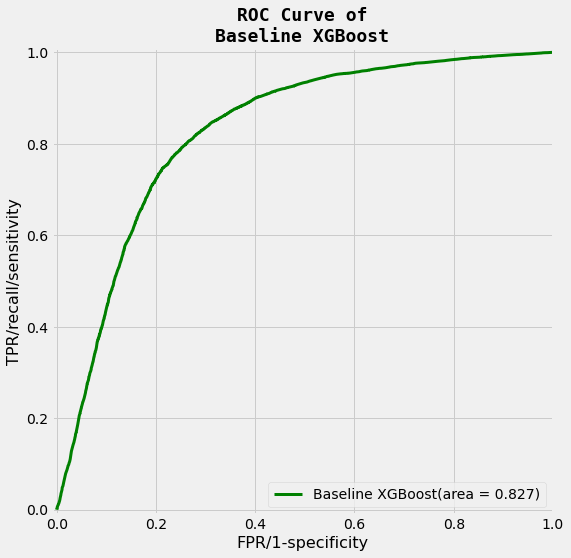

In [117]:
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
roc_auc_grd_xgb = auc(fpr_xgb, tpr_xgb)

# fpr_dummy, tpr_dummy, thresholds_dummy = roc_curve(y_val, dummy_clf.predict_proba(X_val)[:, 1])
# roc_auc_grd_dummy = auc(fpr_dummy, tpr_dummy)

fig, ax = plt.subplots(figsize = (8,8))

# plt.plot(fpr_dummy, tpr_dummy, label="Dummy Classifier(area = {:0.3f})".format(roc_auc_grd_dummy), lw = 2, linestyle='--', color = 'red')
plt.plot(fpr_xgb, tpr_xgb, label="Baseline XGBoost(area = {:0.3f})".format(roc_auc_grd_xgb), lw = 3, color = 'green')

plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.xlabel("FPR/1-specificity", fontsize=16)
plt.ylabel("TPR/recall/sensitivity", fontsize=16)
plt.title('ROC Curve of\nBaseline XGBoost', fontsize=18, fontfamily = 'monospace', fontweight = 'bold')
plt.legend(loc=4)

In [118]:
xgb_score = cross_val_score(model, X_val, y_val, scoring = 'accuracy', cv=10)
print(f'Mean model score: {xgb_score.mean():.3f} ± {xgb_score.std():.3f}')

Mean model score: 0.773 ± 0.004


In [119]:
# initialize data of lists.
data = {
    'Metrics': ['True Negative','False Positive','False Negative','True Positive', 'CV Accuracy Avg', 'CV Accuracy Std'],
    'Baseline':[tn, fp, fn, tp, xgb_score.mean(), xgb_score.std()]
}

# Create DataFrame
metrics_eval = pd.DataFrame(data)

metrics_eval

,Metrics,Baseline
0,True Negative,8342.000000
1,False Positive,3966.000000
2,False Negative,2279.000000
3,True Positive,13127.000000
4,CV Accuracy Avg,0.772606
5,CV Accuracy Std,0.003638


              precision    recall  f1-score   support

           0       0.79      0.68      0.73     12308
           1       0.77      0.85      0.81     15406

    accuracy                           0.77     27714
   macro avg       0.78      0.76      0.77     27714
weighted avg       0.78      0.77      0.77     27714



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


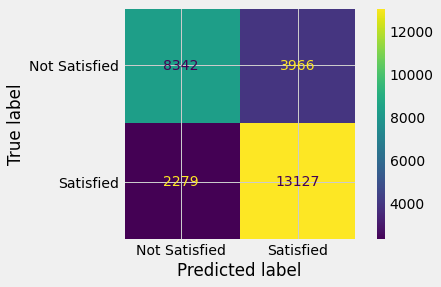

In [120]:
print(metrics.classification_report(expected_y, predicted_y))

metrics.plot_confusion_matrix(
    model,
    X_val,
    y_val,
    values_format = 'd',
    display_labels = ['Not Satisfied','Satisfied']
)

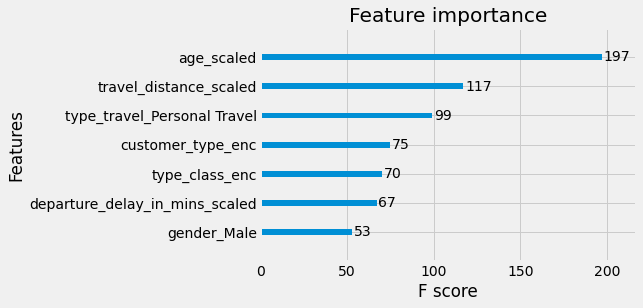

In [121]:
xgb.plot_importance(model)

### Make Submission

In [122]:
test_data = data_engineering_travel(test_travel_pl)
test_data.head()

,id,age_scaled,travel_distance_scaled,departure_delay_in_mins_scaled,arrival_delay_in_mins_scaled,customer_type_enc,type_class_enc,gender_Female,gender_Male,type_travel_Business Travel,type_travel_Personal Travel
0,99900001,0.371795,0.070695,0.000000,0.000000,0,1,1,0,1,0
1,99900002,0.179487,0.201672,0.009202,0.028866,0,1,1,0,1,0
2,99900003,0.679487,0.408038,0.000000,0.000000,1,1,0,1,1,0
3,99900004,0.282051,0.190965,0.000000,0.000000,1,0,1,0,0,1
4,99900005,0.141026,0.228806,0.017382,0.000000,0,1,0,1,1,0


In [123]:
test_prediction_xgb = model.predict(test_data.drop(columns = ['id', 'arrival_delay_in_mins_scaled', 'gender_Female', 'type_travel_Business Travel']))
id = test_data.id
# pd.merge(label_encode, OHE, left_index=True, right_index=True)
submission_xgb = pd.merge(id, pd.DataFrame(data = test_prediction_xgb, columns = ["Overall_Experience"]), left_index=True, right_index=True)
submission_xgb = submission_xgb.rename(columns = {'id':'ID'})

In [124]:
submission_xgb.head()

,ID,Overall_Experience
0,99900001,0
1,99900002,1
2,99900003,1
3,99900004,1
4,99900005,1


In [125]:
submission_xgb.to_csv("/content/drive/MyDrive/Colab Notebooks/MIT_IDSS/hackaton/submission_xgb.csv", index=False)

### Combined

In [126]:
# XGB baseline

model_com = xgb.XGBClassifier(verbosity = 0)
model_com.fit(X_train_com, y_train_com)

XGBClassifier(verbosity=0)

In [127]:
model_com.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'nthread': 1,
 'objective': 'binary:logistic',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 0,
 'subsample': 1,
 'verbosity': 0}

In [128]:
expected_y_train  = y_train_com
predicted_y_train = model_com.predict(X_train_com)

tn_train, fp_train, fn_train, tp_train = metrics.confusion_matrix(expected_y_train, predicted_y_train).ravel()
conf_matrix_train = metrics.confusion_matrix(expected_y_train, predicted_y_train)

expected_y  = y_val_com
predicted_y = model_com.predict(X_val_com)

tn, fp, fn, tp = metrics.confusion_matrix(expected_y, predicted_y).ravel()
conf_matrix = metrics.confusion_matrix(expected_y, predicted_y)

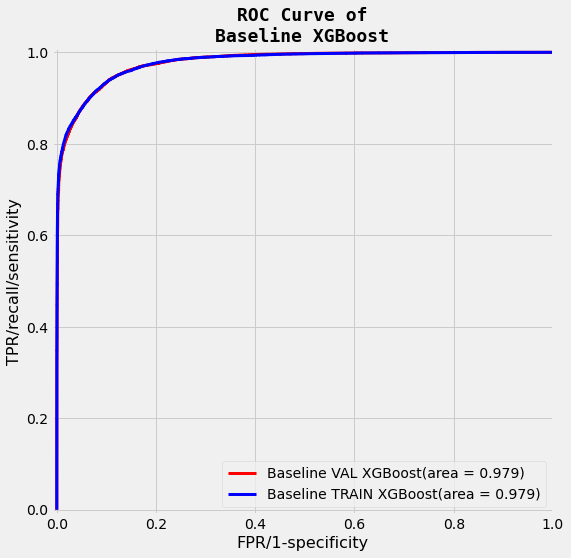

In [129]:
fpr_xgb_train, tpr_xgb_train, thresholds_xgb_train = roc_curve(y_train_com, model_com.predict_proba(X_train_com)[:, 1])
roc_auc_grd_xgb_train = auc(fpr_xgb_train, tpr_xgb_train)

fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_val_com, model_com.predict_proba(X_val_com)[:, 1])
roc_auc_grd_xgb = auc(fpr_xgb, tpr_xgb)

# fpr_dummy, tpr_dummy, thresholds_dummy = roc_curve(y_val_com, dummy_clf.predict_proba(X_val_com)[:, 1])
# roc_auc_grd_dummy = auc(fpr_dummy, tpr_dummy)

fig, ax = plt.subplots(figsize = (8,8))

# plt.plot(fpr_dummy, tpr_dummy, label="Dummy Classifier(area = {:0.3f})".format(roc_auc_grd_dummy), lw = 2, linestyle='--', color = 'red')
plt.plot(fpr_xgb, tpr_xgb, label="Baseline VAL XGBoost(area = {:0.3f})".format(roc_auc_grd_xgb), lw = 3, color = 'red')
plt.plot(fpr_xgb_train, tpr_xgb_train, label="Baseline TRAIN XGBoost(area = {:0.3f})".format(roc_auc_grd_xgb_train), lw = 3, color = 'blue')

plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.xlabel("FPR/1-specificity", fontsize=16)
plt.ylabel("TPR/recall/sensitivity", fontsize=16)
plt.title('ROC Curve of\nBaseline XGBoost', fontsize=18, fontfamily = 'monospace', fontweight = 'bold')
plt.legend(loc=4)

In [130]:
xgb_score = cross_val_score(model_com, X_val_com, y_val_com, scoring = 'accuracy', cv=10)
print(f'Mean model score: {xgb_score.mean():.3f} ± {xgb_score.std():.3f}')

Mean model score: 0.917 ± 0.005


              precision    recall  f1-score   support

           0       0.90      0.91      0.91     28814
           1       0.93      0.92      0.93     35623

    accuracy                           0.92     64437
   macro avg       0.92      0.92      0.92     64437
weighted avg       0.92      0.92      0.92     64437



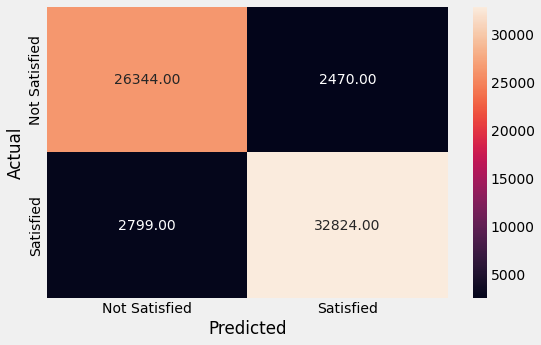

In [148]:
metrics_score(expected_y_train, predicted_y_train)

# print(metrics.classification_report(expected_y_train, predicted_y_train))

# metrics.plot_confusion_matrix(
#     model_com,
#     X_train_com,
#     y_train_com,
#     values_format = 'd',
#     display_labels = ['Not Satisfied','Satisfied']
# )

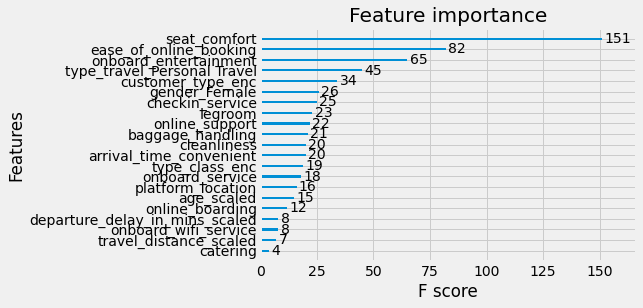

In [132]:
xgb.plot_importance(model_com)

In [150]:
params = {
    'max_depth': [3,6,10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000],
    'colsample_bytree': [0.5, 0.7, 0.9],
    # 'subsample': [0.5, 0.7, 0.9],
    # 'gamma': np.arange (1, 7, 2),
    'reg_alpha' : [0.2, 0.5, 0.8, 1]
}

xgb_grid = GridSearchCV(
    estimator=model_com,
    scoring = 'accuracy',
    param_grid=params, 
    cv=2,
    n_jobs = -1,
    return_train_score = True
)

In [ ]:
xgb_grid.fit(X_train_com,y_train_com)

In [ ]:
acc = accuracy_score(xgb_grid.predict(X_val_com),y_val_com)
print(acc)

In [ ]:
xgb_grid.best_params_

## Deep Learning

In [133]:
import tensorflow as tf
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Dense, BatchNormalization, Dropout

In [149]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [134]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [135]:
epochs = 500
batch = 128
lr = 0.0001
adam = optimizers.Adam(lr)

### Travel only

In [136]:
model_1 = Sequential()
model_1.add(Dense(X_train.shape[1], input_dim=(X_train.shape[1])))
model_1.add(BatchNormalization())
model_1.add(Dense(27, activation='relu'))
model_1.add(Dropout(0.1))
model_1.add(Dense(18, activation='relu'))
model_1.add(Dropout(0.1))
model_1.add(Dense(9, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))

In [137]:
# Compile model
model_1.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 56        
                                                                 
 batch_normalization (BatchN  (None, 7)                28        
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 27)                216       
                                                                 
 dropout (Dropout)           (None, 27)                0         
                                                                 
 dense_2 (Dense)             (None, 18)                504       
                                                                 
 dropout_1 (Dropout)         (None, 18)                0         
                                                        

In [138]:
model_1_history = model_1.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val), 
    epochs=epochs, 
    batch_size = batch,
    callbacks=[callback], 
    verbose=0
    )

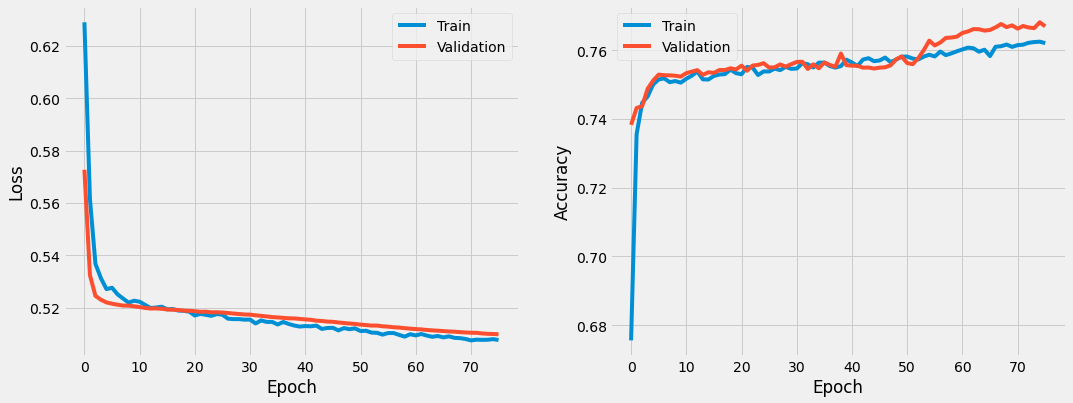

In [139]:
fig, ax = plt.subplots(1,2,figsize = (16,6))

ax[0].plot(model_1_history.history['loss'], label = "Train")
ax[0].plot(model_1_history.history['val_loss'], label = "Validation")

ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='best')

ax[1].plot(model_1_history.history['accuracy'], label = "Train")
ax[1].plot(model_1_history.history['val_accuracy'], label = "Validation")

ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='best')

### Combined

In [140]:
model_1_com = Sequential()

model_1_com.add(BatchNormalization(input_dim=(X_train_com.shape[1])))
model_1_com.add(Dense(X_train_com.shape[1], activation='gelu'))

# model_1_com.add(Dense(X_train_com.shape[1], input_dim=(X_train_com.shape[1])))
# model_1_com.add(BatchNormalization())

# model_1_com.add(Dense(X_train_com.shape[1]*3, activation='relu'))
# model_1_com.add(Dropout(0.3))
# model_1_com.add(Dense(X_train_com.shape[1]*2, activation='relu'))
# model_1_com.add(Dropout(0.5))

model_1_com.add(Dense(X_train_com.shape[1], activation='gelu'))
model_1_com.add(Dense(1, activation='sigmoid'))

In [141]:
# Compile model
model_1_com.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model_1_com.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_1 (Batc  (None, 22)               88        
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 22)                506       
                                                                 
 dense_6 (Dense)             (None, 22)                506       
                                                                 
 dense_7 (Dense)             (None, 1)                 23        
                                                                 
Total params: 1,123
Trainable params: 1,079
Non-trainable params: 44
_________________________________________________________________


In [142]:
model_1_com_history = model_1_com.fit(
    X_train_com, y_train_com, 
    validation_data=(X_val_com, y_val_com), 
    epochs=epochs, 
    batch_size = batch,
    callbacks=[callback], 
    verbose=0
    )

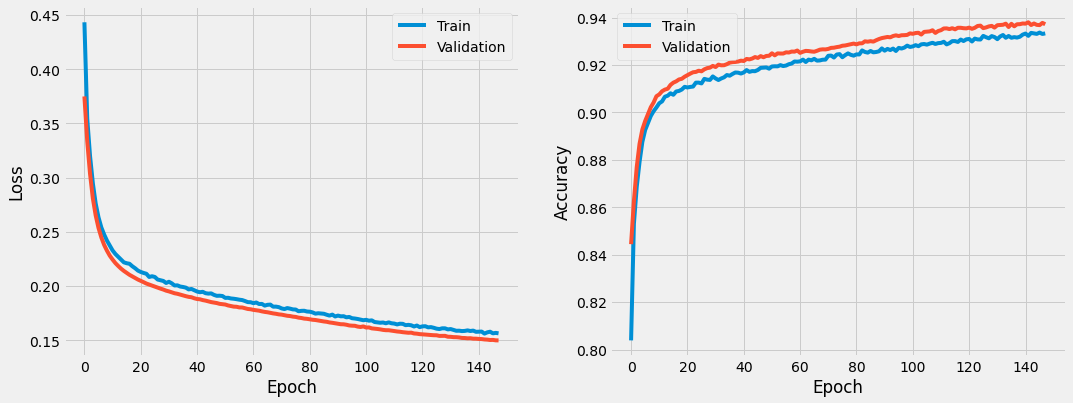

In [143]:
fig, ax = plt.subplots(1,2,figsize = (16,6))

ax[0].plot(model_1_com_history.history['loss'], label = "Train")
ax[0].plot(model_1_com_history.history['val_loss'], label = "Validation")

ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='best')

ax[1].plot(model_1_com_history.history['accuracy'], label = "Train")
ax[1].plot(model_1_com_history.history['val_accuracy'], label = "Validation")

ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='best')

In [144]:
model_3 = Sequential()
model_3.add(Dense(256, activation='tanh', input_shape=(X_train_com.shape[1],)))
model_3.add(Dropout(0.10))
model_3.add(Dense(128, activation='tanh'))
model_3.add(Dropout(0.10))
model_3.add(Dense(64, activation='tanh'))
model_3.add(Dropout(0.10))
model_3.add(Dense(32, activation='tanh'))
model_3.add(Dense(1, activation='sigmoid'))

In [145]:
# Compile model
model_3.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 256)               5888      
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 32)               

In [146]:
model_3_history = model_3.fit(
    X_train_com, y_train_com, 
    validation_data=(X_val_com, y_val_com), 
    epochs=epochs, 
    batch_size = batch,
    callbacks=[callback], 
    verbose=0
    )

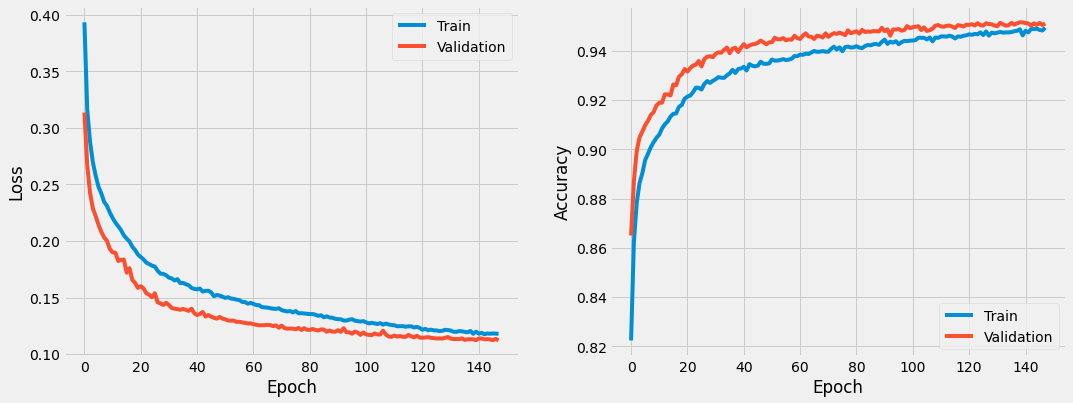

In [147]:
fig, ax = plt.subplots(1,2,figsize = (16,6))

ax[0].plot(model_3_history.history['loss'], label = "Train")
ax[0].plot(model_3_history.history['val_loss'], label = "Validation")

ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='best')

ax[1].plot(model_3_history.history['accuracy'], label = "Train")
ax[1].plot(model_3_history.history['val_accuracy'], label = "Validation")

ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='best')